# ROC paper PGS analysis
Catarina, 2025 

In [1]:
setwd("/Users/drt65393/Documents/roc/roc_paper_2024/pgs_analysis_2025/")

ERROR: Error in setwd("/Users/drt65393/Documents/roc/roc_paper_2024/pgs_analysis_2025/"): não é possível mudar o diretório de trabalho


In [2]:
# load packages
suppressPackageStartupMessages({
require(tidyverse)
require(data.table)
require(boot)
require(haven)
require(fitdistrplus)
require(reshape2)
require(rcompanion)
library(psych)
library(foreign)
library(pastecs)
library(reshape2)
library(Hmisc)
library(glmnet)})

## PGSs from PGS-calc

In [3]:
all_pgs = read.delim("./score/rocgda_pgs.txt")

In [4]:
head(all_pgs); dim(all_pgs)

,sampleset,FID,IID,PGS,SUM,Z_MostSimilarPop,Z_norm1,Z_norm2,percentile_MostSimilarPop
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,reference,HG00096,HG00096,PGS000133_hmPOS_GRCh38,4.38986,-1.5956023,-1.6581548,-1.6142165,4.6476762
2,reference,HG00097,HG00097,PGS000133_hmPOS_GRCh38,4.08643,-1.8590286,-2.0499134,-1.9966995,3.2983508
3,reference,HG00099,HG00099,PGS000133_hmPOS_GRCh38,5.44472,-0.6798135,-0.7790387,-0.7561470,24.4377811
4,reference,HG00100,HG00100,PGS000133_hmPOS_GRCh38,6.93194,0.6113337,0.8064209,0.7838195,72.8635682
5,reference,HG00101,HG00101,PGS000133_hmPOS_GRCh38,3.33441,-2.5119034,-2.6800459,-2.6060008,0.7496252
6,reference,HG00102,HG00102,PGS000133_hmPOS_GRCh38,6.58546,0.3105331,0.2803131,0.2715208,61.7691154


[1] 56880     9

In [5]:
table(all_pgs$sampleset)


reference    rocgda 
    49950      6930 

In [6]:
all_pgs = subset(all_pgs, all_pgs$sampleset=="rocgda")

In [7]:
# Using Z_norm1 as it is corrected by ancestry
all_pgs = all_pgs[, c("FID", "PGS", "Z_norm1")]

all_pgs |>
  pivot_wider(
    names_from = PGS,values_from = Z_norm1
  ) -> all_pgs

In [8]:
# Rename colunmns
head(all_pgs, 5)

FID,PGS000133_hmPOS_GRCh38,PGS000193_hmPOS_GRCh38,PGS000327_hmPOS_GRCh38,PGS001049_hmPOS_GRCh38,PGS001910_hmPOS_GRCh38,PGS001932_hmPOS_GRCh38,PGS002098_hmPOS_GRCh38,PGS002124_hmPOS_GRCh38,PGS002222_hmPOS_GRCh38,PGS002738_hmPOS_GRCh38,PGS002786_hmPOS_GRCh38,PGS003358_hmPOS_GRCh38,PGS003724_hmPOS_GRCh38,PGS003753_hmPOS_GRCh38,PGS004521_hmPOS_GRCh38
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
206182310135-R01C01,2.0843612,1.1997785,0.5457539,0.17445736,0.54256795,-0.5531977,1.35740517,1.7342669,1.7117658,0.2816256,1.6119420,0.20220784,0.6495411,0.9335897,0.7683924
206182310135-R02C01,1.4144541,0.8610277,0.1372860,-0.14364628,1.18855007,1.1997054,-0.47799854,0.1599348,-0.3568822,-1.8294617,0.2737329,-0.06071188,-2.3025308,-1.3664342,2.4419432
206182310135-R03C01,1.1299422,-0.8714149,0.9624963,-1.20322557,0.05025474,1.5662755,0.08514039,0.5296207,0.3339341,-0.3324488,2.5372918,1.19579160,-0.4822738,0.9679354,1.7621284
206182310135-R04C01,-0.8679201,-0.2199581,-0.8366844,0.06854048,0.86739459,0.3627966,0.34366486,-0.9995734,0.1637868,-1.8803174,-0.8653759,1.03873388,2.0920458,0.3938854,-1.0834491
206182310135-R05C01,1.1740682,1.1731933,0.3944135,-0.51825707,-1.66116280,-0.7731703,0.46466454,0.3953966,-0.1061701,-0.5437400,1.5916209,-0.13140753,-0.9153862,1.6923068,-0.1407761


In [9]:
colnames(all_pgs) = c("sample",
  "PGS000133_SCZ",
  "PGS000193_MDD",
  "PGS000327_ASD",
  "PGS001049_risk_behavior",
  "PGS001910_cannabis_use",
  "PGS001932_Insomnia",
  "PGS002098_eating_disorder",
  "PGS002124_addictive_behavior",
  "PGS002222_self_inj",
  "PGS002738_alcohol_dep",
  "PGS002786_BD",
  "PGS003358_smoking",
  "PGS003724_IQ",
  "PGS003753_ADHD",
  "PGS004521_Anxiety_disorder"
)


In [10]:
all_pgs$sample = gsub("-", "_", all_pgs$sample)

In [11]:
head(all_pgs); dim(all_pgs)

sample,PGS000133_SCZ,PGS000193_MDD,PGS000327_ASD,PGS001049_risk_behavior,PGS001910_cannabis_use,PGS001932_Insomnia,PGS002098_eating_disorder,PGS002124_addictive_behavior,PGS002222_self_inj,PGS002738_alcohol_dep,PGS002786_BD,PGS003358_smoking,PGS003724_IQ,PGS003753_ADHD,PGS004521_Anxiety_disorder
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
206182310135_R01C01,2.0843612,1.1997785,0.5457539,0.17445736,0.54256795,-0.5531977,1.35740517,1.7342669,1.7117658,0.28162557,1.6119420,0.20220784,0.6495411,0.9335897,0.7683924
206182310135_R02C01,1.4144541,0.8610277,0.1372860,-0.14364628,1.18855007,1.1997054,-0.47799854,0.1599348,-0.3568822,-1.82946174,0.2737329,-0.06071188,-2.3025308,-1.3664342,2.4419432
206182310135_R03C01,1.1299422,-0.8714149,0.9624963,-1.20322557,0.05025474,1.5662755,0.08514039,0.5296207,0.3339341,-0.33244882,2.5372918,1.19579160,-0.4822738,0.9679354,1.7621284
206182310135_R04C01,-0.8679201,-0.2199581,-0.8366844,0.06854048,0.86739459,0.3627966,0.34366486,-0.9995734,0.1637868,-1.88031739,-0.8653759,1.03873388,2.0920458,0.3938854,-1.0834491
206182310135_R05C01,1.1740682,1.1731933,0.3944135,-0.51825707,-1.66116280,-0.7731703,0.46466454,0.3953966,-0.1061701,-0.54374004,1.5916209,-0.13140753,-0.9153862,1.6923068,-0.1407761
206182310135_R06C01,-0.7364528,-0.6965300,0.5817804,-0.95905479,0.48770896,0.2523123,-1.10034286,-1.4327885,-0.7508859,-0.00508326,0.4201036,0.31167511,-0.3836786,2.3033012,-0.8593635


[1] 462  16

In [12]:
# Reading phenotypes
roc = read_dta('/Users/drt65393/Documents/ROC_GDA/dataset/roc_gda.dta')

In [13]:
dim(roc)

[1] 497 627

In [14]:
roc = roc[, c("ID", "count", "bl0gender", "pemotion", "pconduct", "phyper", "ppeer", "pprosoc", "pebdtot")]

In [15]:
head(roc) 

ID,count,bl0gender,pemotion,pconduct,phyper,ppeer,pprosoc,pebdtot
<chr>,<chr>,<dbl+lbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1003,206425690004_R04_C01,0,4,6,6,3,10,19
1006,206216940091_R03_C01,0,NA,10,NA,4,10,NA
1007,206216930127_R08_C01,1,7,3,6,7,6,23
1011,206425690038_R07_C01,1,6,5,5,2,9,18
1026,206182320116_R08_C01,1,3,3,4,1,7,11
1038,206216930093_R02_C01,0,0,2,0,2,10,4


In [16]:
colnames(roc)[2] = "sample"; colnames(roc)[3] = "sex"

In [17]:
roc$sample = sub("_(?=[^_]*$)", "", roc$sample, perl = TRUE)

In low-risk or general population samples, it may be better to use an alternative three-subscale division of the SDQ into 'internalising problems' (emotional+peer symptoms, 10 items), 'externalising problems' (conduct+hyperactivity symptoms, 10 items) and the prosocial scale (5 items) (Goodman et al, 2010).

In [18]:
roc$externalising = roc$pconduct + roc$phyper
roc$internalising = roc$pemotion + roc$ppeer

In [19]:
roc = na.omit(roc); dim(roc)

[1] 488  11

In [20]:
# Child gender - 1 is female
roc$sex = ifelse(roc$sex==1, "female", "male")

In [21]:
head(roc)

ID,sample,sex,pemotion,pconduct,phyper,ppeer,pprosoc,pebdtot,externalising,internalising
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1003,206425690004_R04C01,male,4,6,6,3,10,19,12,7
1007,206216930127_R08C01,female,7,3,6,7,6,23,9,14
1011,206425690038_R07C01,female,6,5,5,2,9,18,10,8
1026,206182320116_R08C01,female,3,3,4,1,7,11,7,4
1038,206216930093_R02C01,male,0,2,0,2,10,4,2,2
104,20618230139_R03C01,female,3,6,5,5,10,19,11,8


 The Strengths and Difficulties Questionnaire (SDQ) uses cutoff scores to categorize individuals' psychosocial difficulties. The externalizing behavior subscale, which combines conduct problems and hyperactivity, has cutoff scores for identifying normal, borderline, and abnormal ranges. 

In [ ]:
png("/Users/drt65393/Documents/Doc/TESE/figuras/int_ext_histograms.png", width=1500, height=1000, res=300)

par( mfrow=c(1,2), mar=c(5,5,2,1), bg = "white" ) 
hist(roc$externalising, breaks=10 , xlim=c(0,20) , col=rgb(1,0,0,0.5) , xlab="Externalizing" , ylab="Frequency" , main="" ) 
hist(roc$internalising, breaks=10 , xlim=c(0,20) , col=rgb(0,0,1,0.5) , xlab="Internalizing" , ylab="Frequency" , main="") 

dev.off()

In [ ]:
png("/Users/drt65393/Documents/Doc/TESE/figuras/sdq_histograms.png", width=1700, height=1000, res=300)

par( mfrow=c(2,3), mar=c(5,5,2,1), bg = "white" ) 
hist(roc$pemotion, breaks=10 , xlim=c(0,10) , xlab="Emotional symptoms" , ylab="Frequency" , main="" ) 
hist(roc$pconduct, breaks=10 , xlim=c(0,10) , xlab="Conduct problems" , ylab="Frequency" , main="") 
hist(roc$phyper, breaks=10 , xlim=c(0,10) , xlab="Hyperactivity/inattention" , ylab="Frequency" , main="") 
hist(roc$ppeer, breaks=10 , xlim=c(0,10) , xlab="Peer relationship problems" , ylab="Frequency" , main="") 
hist(roc$pebdtot, breaks=15 , xlim=c(0,30) , xlab="SDQ total problems" , ylab="Frequency" , main="")

dev.off()

In [ ]:
par(
  bg = "white"
)
qqnorm(roc$externalising, pch = 1, frame = FALSE, main = "Normal Q-Q Plot for Externalising Behaviors")
qqline(roc$externalising, col = "steelblue", lwd = 2)

## PGS-Externalizing

In [22]:
prscs_ext = fread("/Users/drt65393/Documents/ROC_GDA/09_2025_final_analysis/inputs/2025-12-04-pgs-ext/output/prs/ROC_GDA_externalizing.hg19.profile")

In [23]:
head(prscs_ext)

FID,IID,PHENO,CNT,CNT2,SCORESUM
<chr>,<chr>,<int>,<int>,<int>,<dbl>
206182310135-R01C01,206182310135-R01C01,-9,1937718,722423,-0.08044980
206182310135-R02C01,206182310135-R02C01,-9,1937718,725252,0.08750610
206182310135-R03C01,206182310135-R03C01,-9,1937718,731051,0.00193003
206182310135-R04C01,206182310135-R04C01,-9,1937718,725758,-0.01384740
206182310135-R05C01,206182310135-R05C01,-9,1937718,723187,-0.06018120
206182310135-R06C01,206182310135-R06C01,-9,1937718,723821,-0.08156400


In [24]:
prscs_ext = prscs_ext[, c("FID", "SCORESUM")]
colnames(prscs_ext) = c("sample", "PGS_Ext")
prscs_ext$sample = gsub("-", "_", prscs_ext$sample)

In [25]:
head(prscs_ext)

sample,PGS_Ext
<chr>,<dbl>
206182310135_R01C01,-0.08044980
206182310135_R02C01,0.08750610
206182310135_R03C01,0.00193003
206182310135_R04C01,-0.01384740
206182310135_R05C01,-0.06018120
206182310135_R06C01,-0.08156400


In [26]:
prscs_int = fread("/Users/drt65393/Documents/ROC_GDA/09_2025_final_analysis/inputs/2025-09-08-pgs-int/output/prs/ROC_GDA_internalizing.hg19.profile")

In [27]:
prscs_int = prscs_int[, c("FID", "SCORESUM")]
colnames(prscs_int) = c("sample", "PGS_Int")
prscs_int$sample = gsub("-", "_", prscs_int$sample)
head(prscs_int)

sample,PGS_Int
<chr>,<dbl>
206182310135_R01C01,0.111377000
206182310135_R02C01,0.243459000
206182310135_R03C01,0.245943000
206182310135_R04C01,-0.011444200
206182310135_R05C01,-0.122624000
206182310135_R06C01,-0.000610875


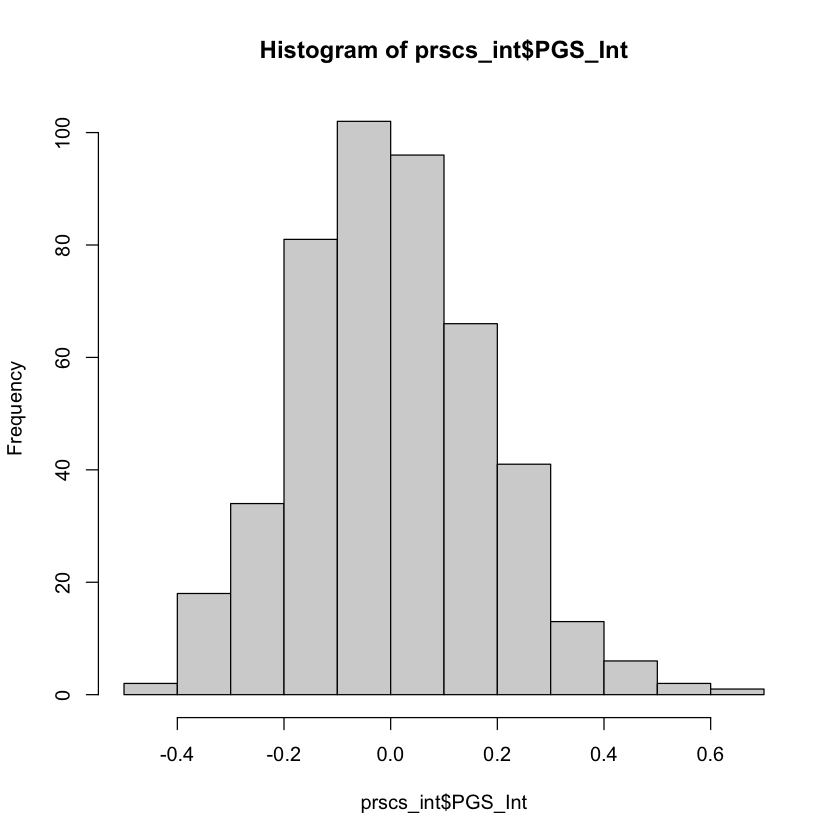

In [28]:
hist(prscs_int$PGS_Int)

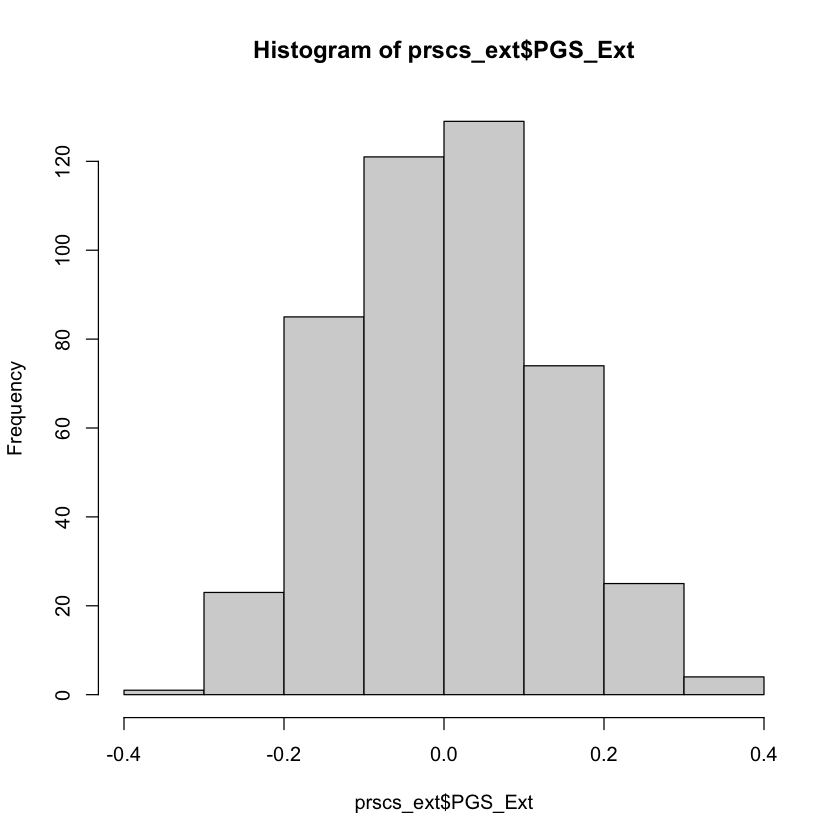

In [29]:
hist(prscs_ext$PGS_Ext)

## Residualize PGS by Principal Components

In [30]:
pcs = read.delim("./score/rocgda_popsimilarity.txt")

In [31]:
colnames(pcs)

[1] "sampleset"                    "FID"                         
 [3] "IID"                          "PC1"                         
 [5] "PC2"                          "PC3"                         
 [7] "PC4"                          "PC5"                         
 [9] "PC6"                          "PC7"                         
[11] "PC8"                          "PC9"                         
[13] "PC10"                         "Unrelated"                   
[15] "RF_P_AFR"                     "RF_P_AMR"                    
[17] "RF_P_CSA"                     "RF_P_EAS"                    
[19] "RF_P_EUR"                     "RF_P_MID"                    
[21] "MostSimilarPop"               "MostSimilarPop_LowConfidence"
[23] "REFERENCE"                    "SuperPop"

In [32]:
head(pcs)

,sampleset,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,⋯,RF_P_AFR,RF_P_AMR,RF_P_CSA,RF_P_EAS,RF_P_EUR,RF_P_MID,MostSimilarPop,MostSimilarPop_LowConfidence,REFERENCE,SuperPop
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,rocgda,206182310135-R01C01,206182310135-R01C01,8.5758,-19.9273,14.8068,-8.6068,-1.6859,-1.7737,2.4812,⋯,0.00,0.99,0,0,0.00,0.01,AMR,False,False,
2,rocgda,206182310135-R02C01,206182310135-R02C01,18.7834,-14.7949,13.1148,-6.7245,-0.6911,-1.8074,1.1749,⋯,0.00,1.00,0,0,0.00,0.00,AMR,False,False,
3,rocgda,206182310135-R03C01,206182310135-R03C01,6.2075,-22.8159,9.9667,-9.4797,-3.3636,-0.8896,4.6829,⋯,0.00,0.99,0,0,0.00,0.01,AMR,False,False,
4,rocgda,206182310135-R04C01,206182310135-R04C01,15.8160,-13.6565,14.9441,-4.0439,-1.3585,-0.8006,2.3802,⋯,0.00,1.00,0,0,0.00,0.00,AMR,False,False,
5,rocgda,206182310135-R05C01,206182310135-R05C01,34.7519,-10.5412,7.5596,-7.1871,0.6395,-0.4821,-0.3382,⋯,0.37,0.61,0,0,0.00,0.02,AMR,False,False,
6,rocgda,206182310135-R06C01,206182310135-R06C01,26.0155,-9.2844,14.5485,-4.3111,-1.7952,-2.7575,1.5301,⋯,0.00,0.99,0,0,0.01,0.00,AMR,False,False,


In [33]:
pcs = pcs[which(pcs$sampleset=="rocgda"), c("FID", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")]

In [34]:
dim(pcs); head(pcs)

[1] 462  11

,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,206182310135-R01C01,8.5758,-19.9273,14.8068,-8.6068,-1.6859,-1.7737,2.4812,-1.2253,2.7778,-4.6607
2,206182310135-R02C01,18.7834,-14.7949,13.1148,-6.7245,-0.6911,-1.8074,1.1749,-5.0325,1.1919,-0.8659
3,206182310135-R03C01,6.2075,-22.8159,9.9667,-9.4797,-3.3636,-0.8896,4.6829,-3.0402,4.7321,-0.0871
4,206182310135-R04C01,15.8160,-13.6565,14.9441,-4.0439,-1.3585,-0.8006,2.3802,-3.0002,2.5642,-0.4152
5,206182310135-R05C01,34.7519,-10.5412,7.5596,-7.1871,0.6395,-0.4821,-0.3382,-3.4033,-1.5220,-3.0682
6,206182310135-R06C01,26.0155,-9.2844,14.5485,-4.3111,-1.7952,-2.7575,1.5301,-3.6002,-0.0348,-1.7752


In [35]:
pcs$FID = gsub("-", "_", pcs$FID)
colnames(pcs)[1] = "sample"

In [36]:
# Reorder to match order
prscs_ext = prscs_ext[match(pcs$sample, prscs_ext$sample), ]; dim(prscs_ext)
prscs_int = prscs_int[match(pcs$sample, prscs_int$sample), ]; dim(prscs_int)

[1] 462   2

[1] 462   2

In [37]:
head(prscs_ext); head(prscs_int); head(pcs)

sample,PGS_Ext
<chr>,<dbl>
206182310135_R01C01,-0.08044980
206182310135_R02C01,0.08750610
206182310135_R03C01,0.00193003
206182310135_R04C01,-0.01384740
206182310135_R05C01,-0.06018120
206182310135_R06C01,-0.08156400


sample,PGS_Int
<chr>,<dbl>
206182310135_R01C01,0.111377000
206182310135_R02C01,0.243459000
206182310135_R03C01,0.245943000
206182310135_R04C01,-0.011444200
206182310135_R05C01,-0.122624000
206182310135_R06C01,-0.000610875


,sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,206182310135_R01C01,8.5758,-19.9273,14.8068,-8.6068,-1.6859,-1.7737,2.4812,-1.2253,2.7778,-4.6607
2,206182310135_R02C01,18.7834,-14.7949,13.1148,-6.7245,-0.6911,-1.8074,1.1749,-5.0325,1.1919,-0.8659
3,206182310135_R03C01,6.2075,-22.8159,9.9667,-9.4797,-3.3636,-0.8896,4.6829,-3.0402,4.7321,-0.0871
4,206182310135_R04C01,15.8160,-13.6565,14.9441,-4.0439,-1.3585,-0.8006,2.3802,-3.0002,2.5642,-0.4152
5,206182310135_R05C01,34.7519,-10.5412,7.5596,-7.1871,0.6395,-0.4821,-0.3382,-3.4033,-1.5220,-3.0682
6,206182310135_R06C01,26.0155,-9.2844,14.5485,-4.3111,-1.7952,-2.7575,1.5301,-3.6002,-0.0348,-1.7752


In [38]:
rownames(pcs) = pcs$sample;
pcs$sample = NULL

In [39]:
prscs_ext$PGS_Ext = resid(lm(prscs_ext$PGS_Ext ~ ., data = pcs))

In [40]:
prscs_int$PGS_Int = resid(lm(prscs_int$PGS_Int ~ ., data = pcs))

In [41]:
prscs = merge(prscs_int, prscs_ext, by = "sample")
head(prscs); dim(prscs)

sample,PGS_Int,PGS_Ext
<chr>,<dbl>,<dbl>
206182310135_R01C01,0.08915865,-0.07948094
206182310135_R02C01,0.27126052,0.05753460
206182310135_R03C01,0.22249495,-0.01257991
206182310135_R04C01,-0.05197157,-0.04599166
206182310135_R05C01,-0.02193859,-0.05702520
206182310135_R06C01,-0.01821783,-0.10030967


[1] 462   3

## Models with individual PGS

In [42]:
head(all_pgs)

sample,PGS000133_SCZ,PGS000193_MDD,PGS000327_ASD,PGS001049_risk_behavior,PGS001910_cannabis_use,PGS001932_Insomnia,PGS002098_eating_disorder,PGS002124_addictive_behavior,PGS002222_self_inj,PGS002738_alcohol_dep,PGS002786_BD,PGS003358_smoking,PGS003724_IQ,PGS003753_ADHD,PGS004521_Anxiety_disorder
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
206182310135_R01C01,2.0843612,1.1997785,0.5457539,0.17445736,0.54256795,-0.5531977,1.35740517,1.7342669,1.7117658,0.28162557,1.6119420,0.20220784,0.6495411,0.9335897,0.7683924
206182310135_R02C01,1.4144541,0.8610277,0.1372860,-0.14364628,1.18855007,1.1997054,-0.47799854,0.1599348,-0.3568822,-1.82946174,0.2737329,-0.06071188,-2.3025308,-1.3664342,2.4419432
206182310135_R03C01,1.1299422,-0.8714149,0.9624963,-1.20322557,0.05025474,1.5662755,0.08514039,0.5296207,0.3339341,-0.33244882,2.5372918,1.19579160,-0.4822738,0.9679354,1.7621284
206182310135_R04C01,-0.8679201,-0.2199581,-0.8366844,0.06854048,0.86739459,0.3627966,0.34366486,-0.9995734,0.1637868,-1.88031739,-0.8653759,1.03873388,2.0920458,0.3938854,-1.0834491
206182310135_R05C01,1.1740682,1.1731933,0.3944135,-0.51825707,-1.66116280,-0.7731703,0.46466454,0.3953966,-0.1061701,-0.54374004,1.5916209,-0.13140753,-0.9153862,1.6923068,-0.1407761
206182310135_R06C01,-0.7364528,-0.6965300,0.5817804,-0.95905479,0.48770896,0.2523123,-1.10034286,-1.4327885,-0.7508859,-0.00508326,0.4201036,0.31167511,-0.3836786,2.3033012,-0.8593635


In [43]:
all_pgs = merge(all_pgs, prscs, by="sample", all.x=TRUE); dim(all_pgs)

[1] 462  18

In [44]:
colnames(all_pgs)

[1] "sample"                       "PGS000133_SCZ"               
 [3] "PGS000193_MDD"                "PGS000327_ASD"               
 [5] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
 [7] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
 [9] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[11] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[13] "PGS003358_smoking"            "PGS003724_IQ"                
[15] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[17] "PGS_Int"                      "PGS_Ext"

In [45]:
df = merge(roc, all_pgs, by="sample"); dim(df) # losing 81 samples...

[1] 381  28

In [46]:
colnames(df)

[1] "sample"                       "ID"                          
 [3] "sex"                          "pemotion"                    
 [5] "pconduct"                     "phyper"                      
 [7] "ppeer"                        "pprosoc"                     
 [9] "pebdtot"                      "externalising"               
[11] "internalising"                "PGS000133_SCZ"               
[13] "PGS000193_MDD"                "PGS000327_ASD"               
[15] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
[17] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
[19] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[21] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[23] "PGS003358_smoking"            "PGS003724_IQ"                
[25] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[27] "PGS_Int"                      "PGS_Ext"

No id variables; using all as measure variables



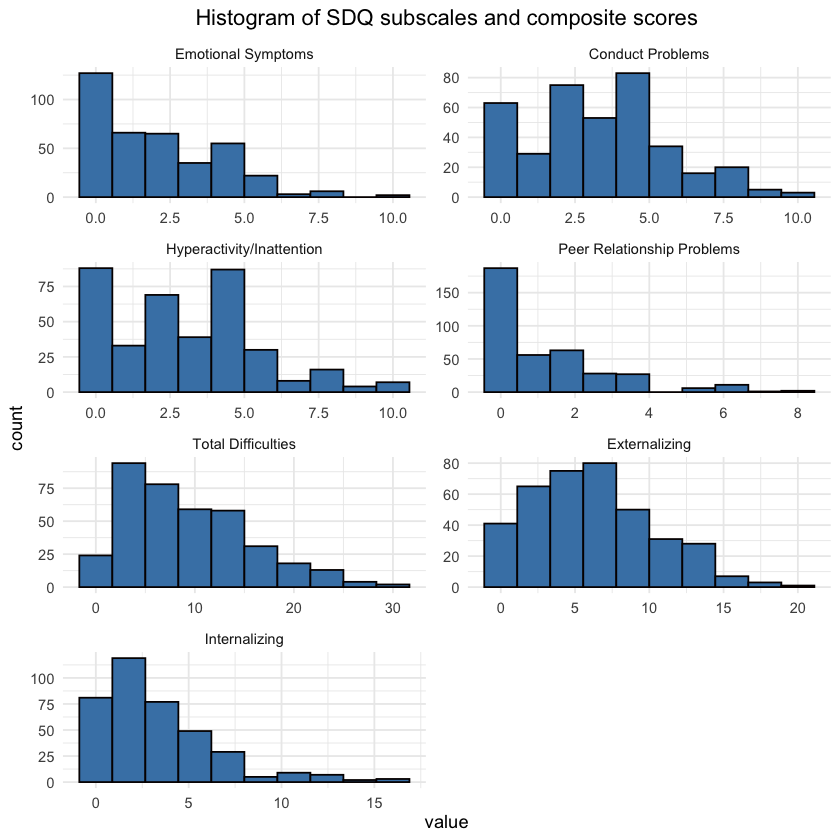

In [47]:
# Phenotypes distribution after merging with PGS

phenotypes = df[, c("pemotion", "pconduct", "phyper", "ppeer", "pebdtot", "externalising", "internalising")]
phenotypes_long = melt(phenotypes)

labels = c(
  pemotion = "Emotional Symptoms",
  pconduct = "Conduct Problems",
  phyper = "Hyperactivity/Inattention",
  ppeer = "Peer Relationship Problems",
  pebdtot = "Total Difficulties",
  externalising = "Externalizing",
  internalising = "Internalizing"
)


ggplot(phenotypes_long, aes(x = value)) +
  geom_histogram(bins = 10, fill = "steelblue", color = "#040000") +
  facet_wrap(~ variable, scales = "free", ncol = 2, labeller = labeller(variable = labels)) +
  theme_minimal() +
    theme(
    plot.title = element_text(hjust = 0.5),
    plot.background = element_rect(fill = "white", color = NA),   # outside background
    panel.background = element_rect(fill = "white", color = NA),  # inside panels
    strip.background = element_rect(fill = "white", color = NA)   # facet labels background
  ) +
  labs(title = "Histogram of SDQ subscales and composite scores") + theme(plot.title = element_text(hjust = 0.5))

ggsave("/Users/drt65393/Documents/Doc/TESE/figuras/phen_hist.png", width = 10, height = 8, dpi = 300)


Although visually the data seems to be compatible with a beta distribution, this wouldnt be adequate since the phenotypes do not range form 0 to 1 and transforming it would make lose interpretability. 

We could use poisson but the data is also overdispersed (variance > mean), so we can use quasi-poisson or neg-binomial. Neg-binomial is more apropriate for when we have a huge overdispersion in the data.


=== Cullen and Phrey for: pemotion ===



=== Cullen and Phrey for: pconduct ===


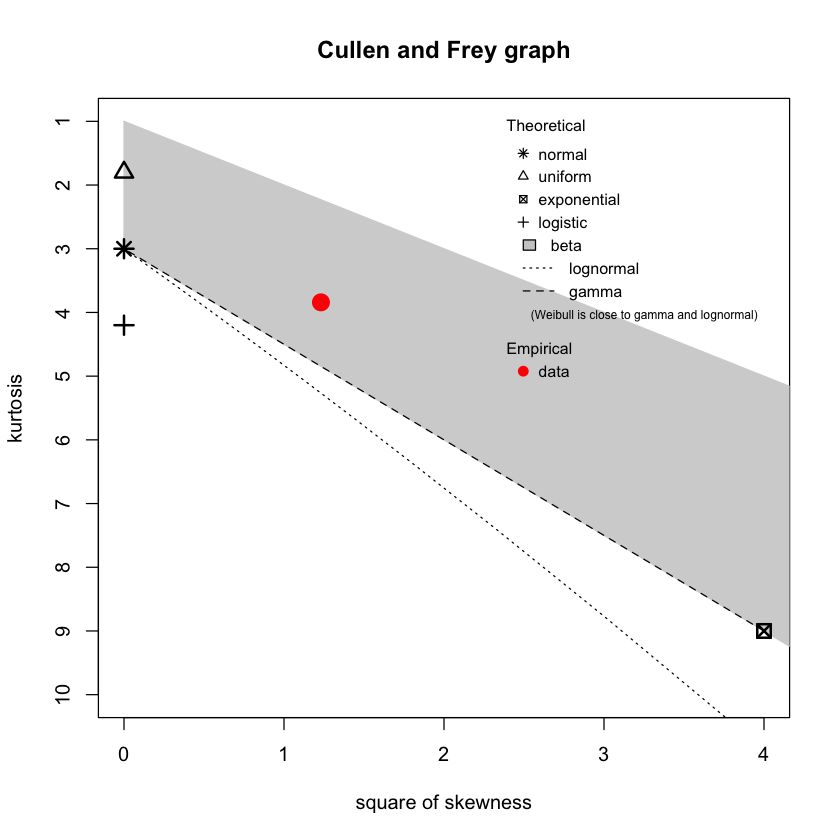


=== Cullen and Phrey for: phyper ===


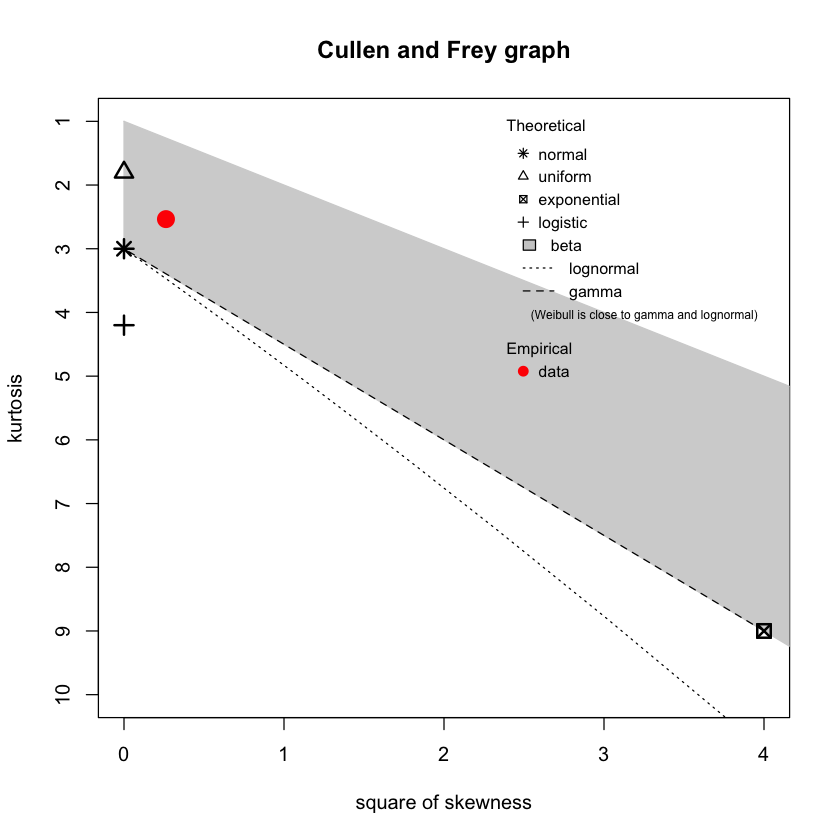


=== Cullen and Phrey for: ppeer ===


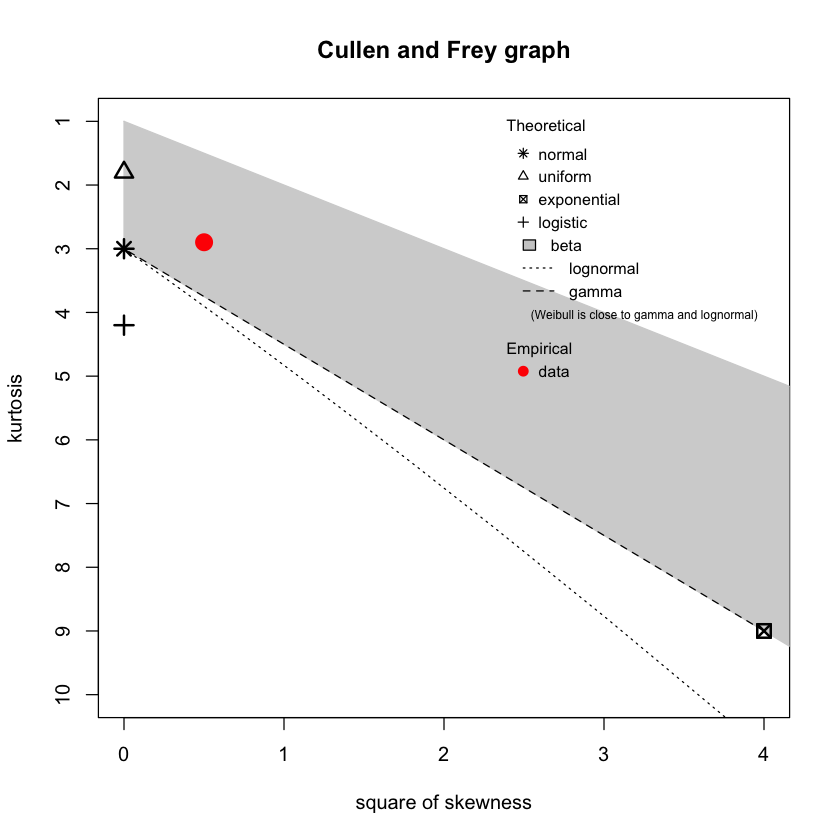


=== Cullen and Phrey for: pebdtot ===


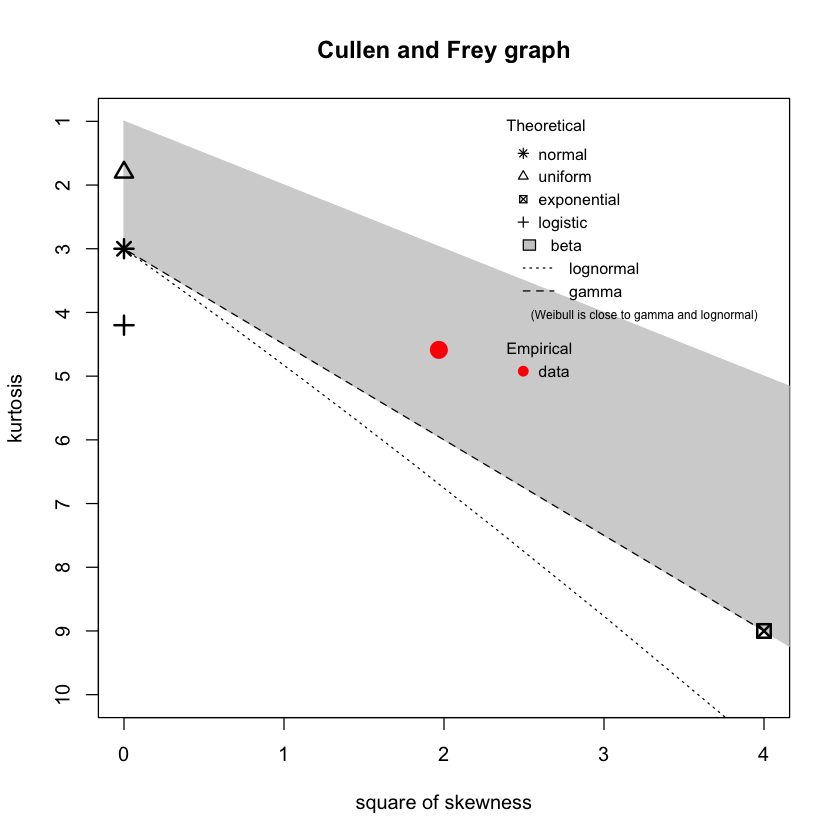


=== Cullen and Phrey for: externalising ===


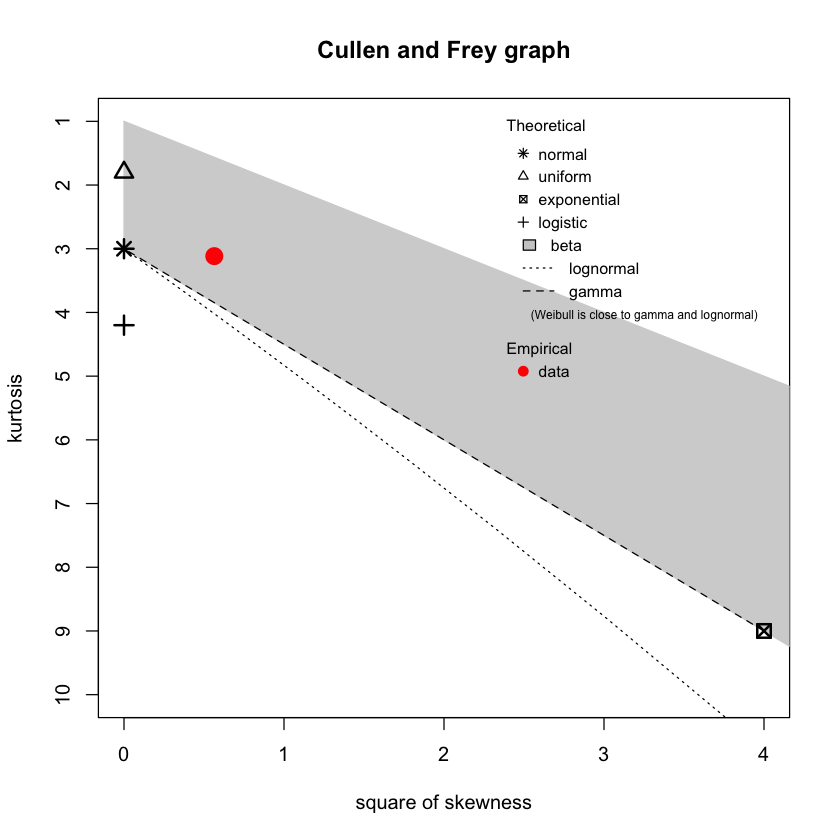


=== Cullen and Phrey for: internalising ===


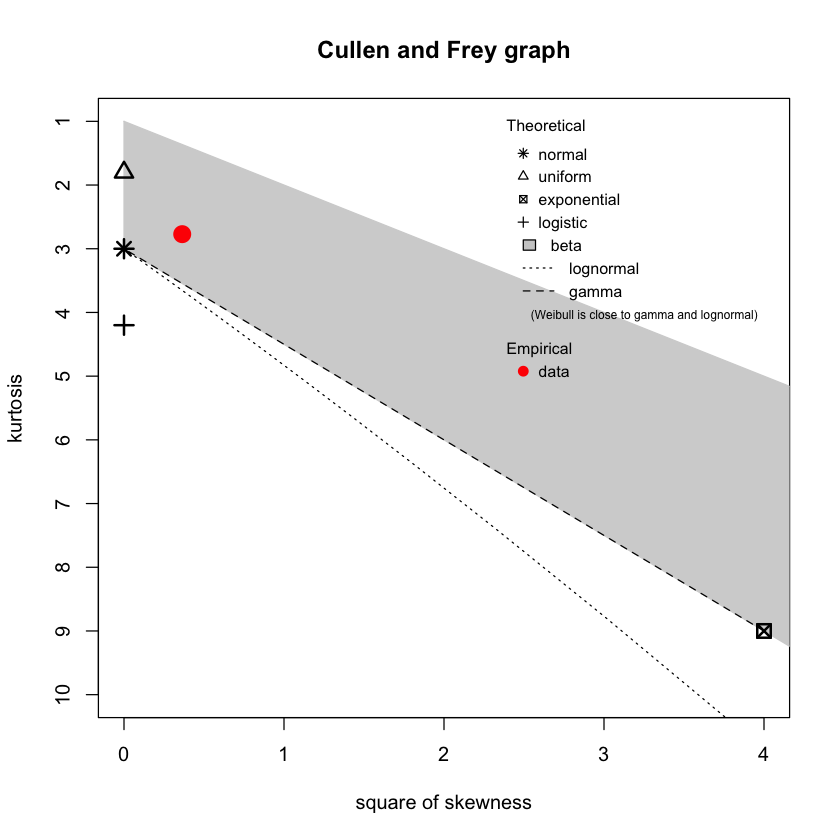

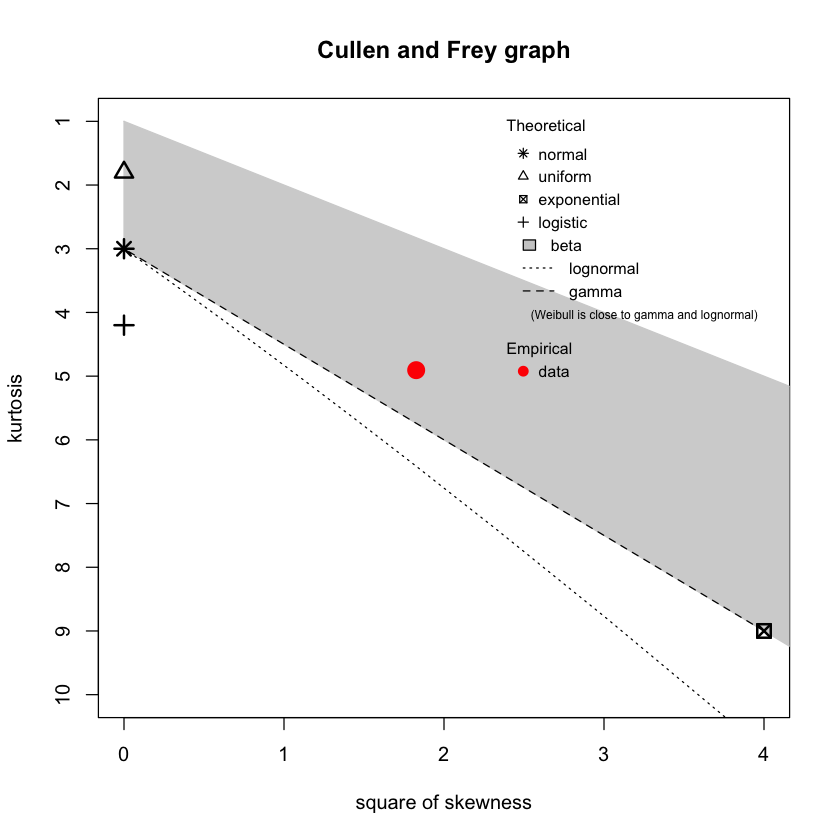

In [129]:
par(bg = "white")
for (col in colnames(phenotypes)) {
  cat("\n=== Cullen and Phrey for:", col, "===\n")
  descdist(phenotypes[[col]])
}

In [130]:
library(MASS)

# Replace with the actual names of your dependent variables
check_overdispersion <- function(y, var_name) {
  mean_y <- mean(y)
  var_y <- var(y)
  id <- var_y / mean_y  # dispersion index
  
  # Fit Poisson model
  poisson_model <- glm(y ~ 1, family = poisson())
  residual_disp <- sum(residuals(poisson_model, type = "pearson")^2) / df.residual(poisson_model)
  
  # Classify overdispersion level
  classification <- if (residual_disp <= 1.5) {
    "No overdispersion (Poisson is appropriate)"
  } else if (residual_disp <= 2) {
    "Mild overdispersion (consider quasi-Poisson)"
  } else if (residual_disp <= 4) {
    "Moderate overdispersion (consider Negative Binomial)"
  } else {
    "Strong overdispersion (use Negative Binomial)"
  }
  
  # Output summary
  cat("\n🔎 Variable:", var_name,
      "\nMean:", round(mean_y, 2),
      "\nVariance:", round(var_y, 2),
      "\nDispersion Index (Var/Mean):", round(id, 2),
      "\nPoisson Residual Dispersion:", round(residual_disp, 2),
      "\n📌 Recommendation:", classification, "\n")
}

# Loop over each dependent variable
for (var in names(phenotypes)) {
  y <- phenotypes[[var]]
  
  # Check if the variable is a valid count (non-negative integers)
  if (all(!is.na(y)) && all(y >= 0) && all(y == floor(y))) {
    check_overdispersion(y, var)
  } else {
    cat("\n⚠️  Variable", var, "is not a non-negative integer count — skipped for Poisson analysis.\n")
  }
}



🔎 Variable: pemotion 
Mean: 1.98 
Variance: 4.37 
Dispersion Index (Var/Mean): 2.21 
Poisson Residual Dispersion: 2.21 
📌 Recommendation: Moderate overdispersion (consider Negative Binomial) 

🔎 Variable: pconduct 
Mean: 3.29 
Variance: 6.03 
Dispersion Index (Var/Mean): 1.84 
Poisson Residual Dispersion: 1.84 
📌 Recommendation: Mild overdispersion (consider quasi-Poisson) 

🔎 Variable: phyper 
Mean: 2.97 
Variance: 6.43 
Dispersion Index (Var/Mean): 2.16 
Poisson Residual Dispersion: 2.16 
📌 Recommendation: Moderate overdispersion (consider Negative Binomial) 

🔎 Variable: ppeer 
Mean: 1.29 
Variance: 2.83 
Dispersion Index (Var/Mean): 2.19 
Poisson Residual Dispersion: 2.19 
📌 Recommendation: Moderate overdispersion (consider Negative Binomial) 

🔎 Variable: pebdtot 
Mean: 9.53 
Variance: 40.56 
Dispersion Index (Var/Mean): 4.26 
Poisson Residual Dispersion: 4.26 
📌 Recommendation: Strong overdispersion (use Negative Binomial) 

🔎 Variable: externalising 
Mean: 6.26 
Variance: 17.39

We also have plenty of evidence in the literature working with SDQ that actually model SDQ subscales/total as counts and use negative-binomial distributions


- Human-Biomonitoring derived exposure and Daily Intakes of Bisphenol A and their associations with neurodevelopmental outcomes among children of the Polish Mother and Child Cohort Study (https://pmc.ncbi.nlm.nih.gov/articles/PMC8390261/)
- Are the estimated needs for mental health care among adolescents from different socioeconomic backgrounds met equally in Sweden? A longitudinal survey-registry linkage study (https://pmc.ncbi.nlm.nih.gov/articles/PMC11272712/)
- How do economic downturns affect the mental health of children? Evidence from the National Health Interview Survey (https://pmc.ncbi.nlm.nih.gov/articles/PMC7427110/)
- Social Functioning as a Mediator between Developmental Language Disorder (DLD) and Emotional Problems in Adolescents (https://pmc.ncbi.nlm.nih.gov/articles/PMC7908163/)
- How do schools influence the emotional and behavioural health of their pupils? A multi-level analysis of 135 schools in the Born in Bradford inner city multi-ethnic birth cohort (https://pmc.ncbi.nlm.nih.gov/articles/PMC11291525/)
- Polygenic risk for mental disorder reveals distinct association profiles across social behaviour in the general population (https://pmc.ncbi.nlm.nih.gov/articles/PMC9095485/)

In [48]:
dependent_vars = names(phenotypes) # All dependent variables
independent_vars = names(all_pgs)[-1] # Exclude the first column (sample) from independent variables

model_results = list()

In [49]:
dependent_vars

[1] "pemotion"      "pconduct"      "phyper"        "ppeer"        
[5] "pebdtot"       "externalising" "internalising"

In [50]:
independent_vars

[1] "PGS000133_SCZ"                "PGS000193_MDD"               
 [3] "PGS000327_ASD"                "PGS001049_risk_behavior"     
 [5] "PGS001910_cannabis_use"       "PGS001932_Insomnia"          
 [7] "PGS002098_eating_disorder"    "PGS002124_addictive_behavior"
 [9] "PGS002222_self_inj"           "PGS002738_alcohol_dep"       
[11] "PGS002786_BD"                 "PGS003358_smoking"           
[13] "PGS003724_IQ"                 "PGS003753_ADHD"              
[15] "PGS004521_Anxiety_disorder"   "PGS_Int"                     
[17] "PGS_Ext"

In [51]:
pgs_df = df[, c("sample", independent_vars)]

In [52]:
dim(pgs_df); colnames(pgs_df)

[1] 381  18

[1] "sample"                       "PGS000133_SCZ"               
 [3] "PGS000193_MDD"                "PGS000327_ASD"               
 [5] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
 [7] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
 [9] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[11] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[13] "PGS003358_smoking"            "PGS003724_IQ"                
[15] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[17] "PGS_Int"                      "PGS_Ext"

In [53]:
getwd()

[1] "/Users/drt65393/Documents/roc/roc_paper_2024/05_2025_pgscalc_analysis"

In [670]:
write.table(pgs_df, file = "./score/08_2025_roc_with_pgs.tsv", sep = "\t", row.names = FALSE, quote = FALSE)

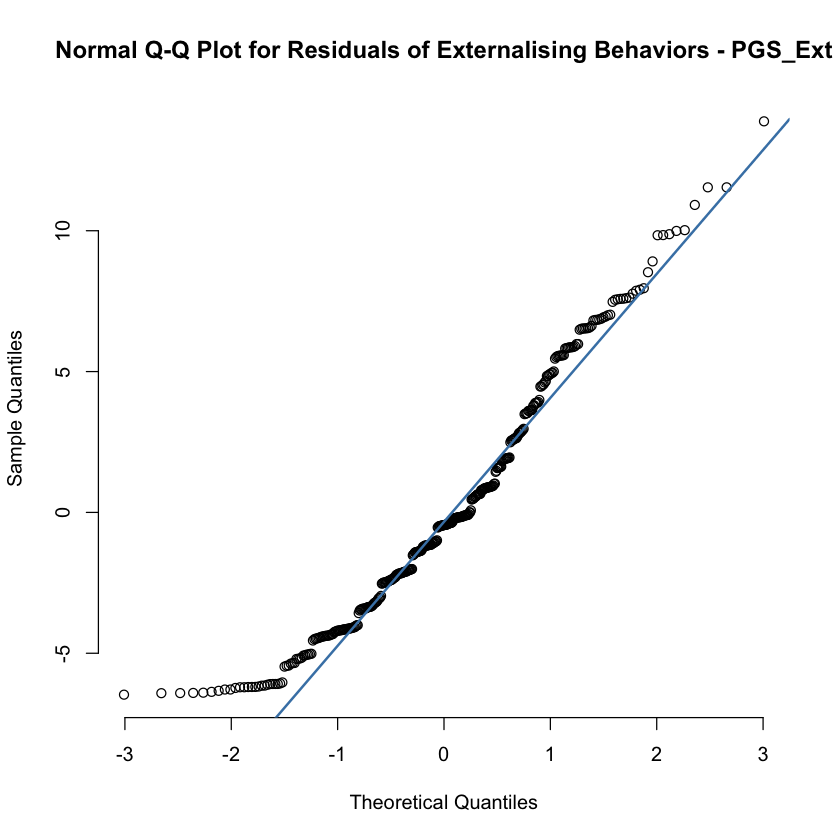

In [236]:
resid(lm(externalising ~ PGS_Ext+sex, data = df)) -> res_ext
par(bg = "white")
qqnorm(res_ext, pch = 1, frame = FALSE, main = "Normal Q-Q Plot for Residuals of Externalising Behaviors - PGS_Ext")
qqline(res_ext, col = "steelblue", lwd = 2)

In [149]:
#############  Negative Binomial regression will be used for the models ########
#############  since all variables are moderate or strong overdispersed ########

In [55]:
length(dependent_vars)

[1] 7

In [56]:
length(independent_vars)

[1] 17

In [57]:
dependent_vars

[1] "pemotion"      "pconduct"      "phyper"        "ppeer"        
[5] "pebdtot"       "externalising" "internalising"

In [58]:
independent_vars

[1] "PGS000133_SCZ"                "PGS000193_MDD"               
 [3] "PGS000327_ASD"                "PGS001049_risk_behavior"     
 [5] "PGS001910_cannabis_use"       "PGS001932_Insomnia"          
 [7] "PGS002098_eating_disorder"    "PGS002124_addictive_behavior"
 [9] "PGS002222_self_inj"           "PGS002738_alcohol_dep"       
[11] "PGS002786_BD"                 "PGS003358_smoking"           
[13] "PGS003724_IQ"                 "PGS003753_ADHD"              
[15] "PGS004521_Anxiety_disorder"   "PGS_Int"                     
[17] "PGS_Ext"

# Testing PGS associations for SDQ total problems

In [59]:
colnames(df)

[1] "sample"                       "ID"                          
 [3] "sex"                          "pemotion"                    
 [5] "pconduct"                     "phyper"                      
 [7] "ppeer"                        "pprosoc"                     
 [9] "pebdtot"                      "externalising"               
[11] "internalising"                "PGS000133_SCZ"               
[13] "PGS000193_MDD"                "PGS000327_ASD"               
[15] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
[17] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
[19] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[21] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[23] "PGS003358_smoking"            "PGS003724_IQ"                
[25] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[27] "PGS_Int"                      "PGS_Ext"

In [60]:
independent_vars

[1] "PGS000133_SCZ"                "PGS000193_MDD"               
 [3] "PGS000327_ASD"                "PGS001049_risk_behavior"     
 [5] "PGS001910_cannabis_use"       "PGS001932_Insomnia"          
 [7] "PGS002098_eating_disorder"    "PGS002124_addictive_behavior"
 [9] "PGS002222_self_inj"           "PGS002738_alcohol_dep"       
[11] "PGS002786_BD"                 "PGS003358_smoking"           
[13] "PGS003724_IQ"                 "PGS003753_ADHD"              
[15] "PGS004521_Anxiety_disorder"   "PGS_Int"                     
[17] "PGS_Ext"

In [61]:
dependent_vars

[1] "pemotion"      "pconduct"      "phyper"        "ppeer"        
[5] "pebdtot"       "externalising" "internalising"

In [63]:
library(tidyverse)

In [66]:
# Fit models

models = lapply(independent_vars, function(x) {
  glm.nb(as.formula(paste("pebdtot ~", x, "+ sex")), data = df)
})

# Tidy results and add Nagelkerke R²
results = lapply(models, function(m) {
  # get predictor name
  predictor = all.vars(formula(m))[2]  # first var after ~

  # compute pseudo-R²
  r2 = nagelkerke(m)$Pseudo.R.squared.for.model.vs.null["Nagelkerke (Cragg and Uhler)", 1]

  broom::tidy(m, exponentiate = TRUE, conf.int = TRUE) |>
    dplyr::filter(term == predictor) |>   # keep only the main predictor
    dplyr::mutate(
      predictor = predictor,
      r2 = r2*100,
      irr_ci = sprintf("%.2f [%.2f, %.2f]", estimate, conf.low, conf.high),
      pval_fmt = ifelse(p.value < 0.001, "<0.001", sprintf("%.3f", p.value)),
      r2_fmt   = sprintf("%.3f", r2)
    )
})

# Bind into single dataframe
results = do.call(rbind, results)

# Keep only predictor of interest (drop intercept, sex)
results = subset(results, term != "(Intercept)" & term != "sex")

results = results %>%
  filter(term != "(Intercept)" & term != "sex") %>%
  mutate(
    sig_level = case_when(
      p.value < 0.01 ~ "p < 0.01",
      p.value < 0.05 ~ "p < 0.05",
      TRUE ~ "no significance"
    ),
    # Label still has stars if you want them
    stars = case_when(
      p.value < 0.01 ~ "**",
      p.value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    label = paste0(term)
  )

In [67]:
dim(results); head(results)

[1] 17 15

term,estimate,std.error,statistic,p.value,conf.low,conf.high,predictor,r2,irr_ci,pval_fmt,r2_fmt,sig_level,stars,label
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PGS000133_SCZ,0.9620095,0.03568883,-1.0852396,0.27781554,0.8973360,1.0314850,PGS000133_SCZ,0.3384920,"0.96 [0.90, 1.03]",0.278,0.338,no significance,,PGS000133_SCZ
PGS000193_MDD,0.9361203,0.03322285,-1.9869235,0.04693088,0.8772177,0.9986967,PGS000193_MDD,1.0671100,"0.94 [0.88, 1.00]",0.047,1.067,p < 0.05,*,PGS000193_MDD
PGS000327_ASD,1.0756692,0.03500172,2.0839839,0.03716163,1.0037291,1.1530089,PGS000327_ASD,1.1360900,"1.08 [1.00, 1.15]",0.037,1.136,p < 0.05,*,PGS000327_ASD
PGS001049_risk_behavior,0.9648972,0.03503337,-1.0199913,0.30773258,0.9017303,1.0323572,PGS001049_risk_behavior,0.3089460,"0.96 [0.90, 1.03]",0.308,0.309,no significance,,PGS001049_risk_behavior
PGS001910_cannabis_use,1.0210596,0.03764843,0.5535657,0.57987610,0.9493964,1.0983126,PGS001910_cannabis_use,0.1102740,"1.02 [0.95, 1.10]",0.580,0.110,no significance,,PGS001910_cannabis_use
PGS001932_Insomnia,1.0036949,0.03538907,0.1042152,0.91699857,0.9371615,1.0748705,PGS001932_Insomnia,0.0305512,"1.00 [0.94, 1.07]",0.917,0.031,no significance,,PGS001932_Insomnia


Warning message:
“Use of `results$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 3, y = length(unique(results$label)) + 1, label = "IRR [95% CI]"), :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `results$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 3.8, y = length(unique(results$label)) + 1, :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `results$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 5.6, y = length(unique(results$label)) + 1, :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use o

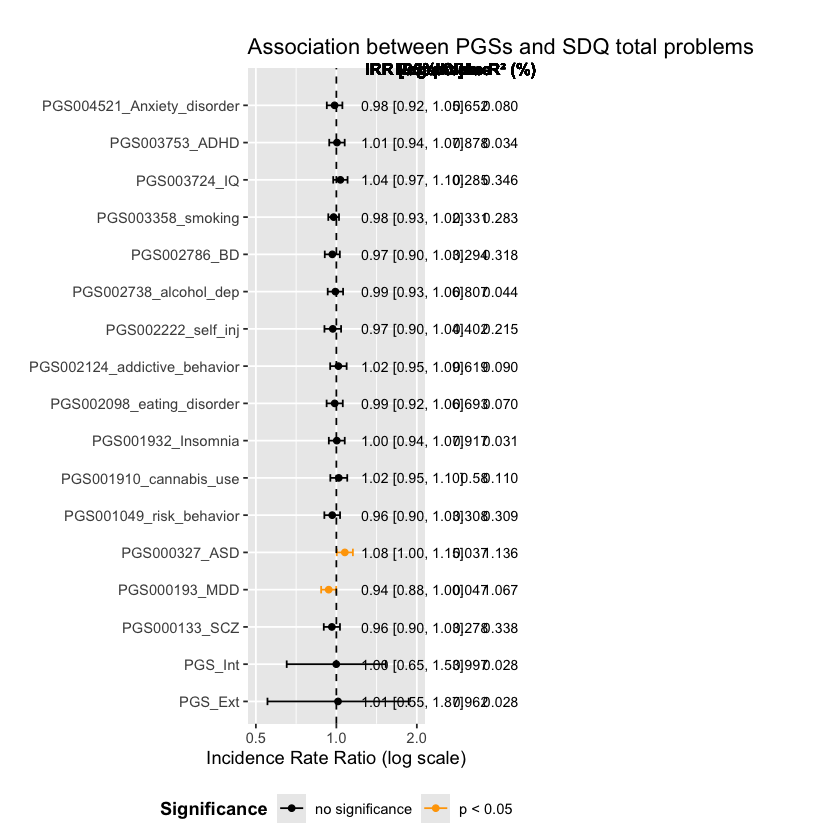

In [68]:
ggplot(results, aes(x = estimate, y = label, color = sig_level)) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
  geom_vline(xintercept = 1, linetype = "dashed") +
  scale_x_log10() +
  scale_color_manual(
    values = c("p < 0.01" = "red",
               "p < 0.05" = "orange",
               "no significance" = "black"),
    name = "Significance"
  ) +
  labs(
    x = "Incidence Rate Ratio (log scale)",
    y = "",
    title = "Association between PGSs and SDQ total problems"
  ) +
  # place IRR [CI] labels
  geom_text(aes(x = 3, label = irr_ci), 
            inherit.aes = FALSE, 
            data = results,
            hjust = 1, size = 3, color = "black", y = results$label) +
  # add IRR [CI] header
  geom_text(aes(x = 3, y = length(unique(results$label)) + 1,
                label = "IRR [95% CI]"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +

  # add p-value header
  geom_text(aes(x = 3.8, y = length(unique(results$label)) + 1,
                label = "p-value"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +

  # add p-value values column
  geom_text(aes(x = 3.7, label = round(p.value,3)), 
            inherit.aes = FALSE, 
            data = results,
            hjust = 1, size = 3, color = "black", y = results$label) +

  # add R² values column
  geom_text(aes(x = 4.8, label = r2_fmt), 
            inherit.aes = FALSE, 
            data = results,
            hjust = 1, size = 3, color = "black", y = results$label) +
  # add R² header
  geom_text(aes(x = 5.6, y = length(unique(results$label)) + 1,
                label = "Nagelkerke R² (%)"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +
  coord_cartesian(xlim = c(0.5, 2), clip = "off") +  
  theme(
    plot.margin = margin(23, 250, 5, 5),  # expand right margin for the extra column
    legend.position = "bottom",
    legend.title = element_text(face = "bold"),
    legend.direction = "horizontal"
  )

  ggsave("/Users/drt65393/Documents/Doc/TESE/figuras/sdq_total.png", width = 11, height = 8, dpi = 300)

In [69]:
colnames(results); dim(results)

[1] "term"      "estimate"  "std.error" "statistic" "p.value"   "conf.low" 
 [7] "conf.high" "predictor" "r2"        "irr_ci"    "pval_fmt"  "r2_fmt"   
[13] "sig_level" "stars"     "label"

[1] 17 15

In [70]:
results$p_fdr = p.adjust(results$p.value, method = "BH")

In [72]:
results[, c("term", "p.value", "p_fdr")] # no significance after multiple test correction

term,p.value,p_fdr
<chr>,<dbl>,<dbl>
PGS000133_SCZ,0.27781554,0.8028456
PGS000193_MDD,0.04693088,0.3989124
PGS000327_ASD,0.03716163,0.3989124
PGS001049_risk_behavior,0.30773258,0.8028456
PGS001910_cannabis_use,0.57987610,0.9817934
PGS001932_Insomnia,0.91699857,0.9966484
PGS002098_eating_disorder,0.69303064,0.9817934
PGS002124_addictive_behavior,0.61916589,0.9817934
PGS002222_self_inj,0.40218815,0.8546498


# Testing PGS associations for SDQ Externalizing problems

In [75]:
# Fit models

models = lapply(independent_vars, function(x) {
  glm.nb(as.formula(paste("externalising ~", x, "+ sex")), data = df)
})

# Tidy results and add Nagelkerke R²
results_ext = lapply(models, function(m) {
  # get predictor name
  predictor <- all.vars(formula(m))[2]  # first var after ~

  # compute pseudo-R²
  r2 <- nagelkerke(m)$Pseudo.R.squared.for.model.vs.null["Nagelkerke (Cragg and Uhler)", 1]

  broom::tidy(m, exponentiate = TRUE, conf.int = TRUE) |>
    dplyr::filter(term == predictor) |>   # keep only the main predictor
    dplyr::mutate(
      predictor = predictor,
      r2 = r2*100,
      irr_ci = sprintf("%.2f [%.2f, %.2f]", estimate, conf.low, conf.high),
      pval_fmt = ifelse(p.value < 0.001, "<0.001", sprintf("%.3f", p.value)),
      r2_fmt   = sprintf("%.3f", r2)
    )
})

# Bind into single dataframe
results_ext = do.call(rbind, results_ext)

# Keep only predictor of interest (drop intercept, sex)
results_ext = subset(results_ext, term != "(Intercept)" & term != "sex")

results_ext <- results_ext %>%
  filter(term != "(Intercept)" & term != "sex") %>%
  mutate(
    sig_level = case_when(
      p.value < 0.01 ~ "p < 0.01",
      p.value < 0.05 ~ "p < 0.05",
      TRUE ~ "no significance"
    ),
    # Label still has stars if you want them
    stars = case_when(
      p.value < 0.01 ~ "**",
      p.value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    label = paste0(term)
  )

Warning message:
“Use of `results_ext$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 3, y = length(unique(results_ext$label)) + :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `results_ext$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 3.8, y = length(unique(results_ext$label)) + :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `results_ext$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 5.6, y = length(unique(results_ext$label)) + :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `results

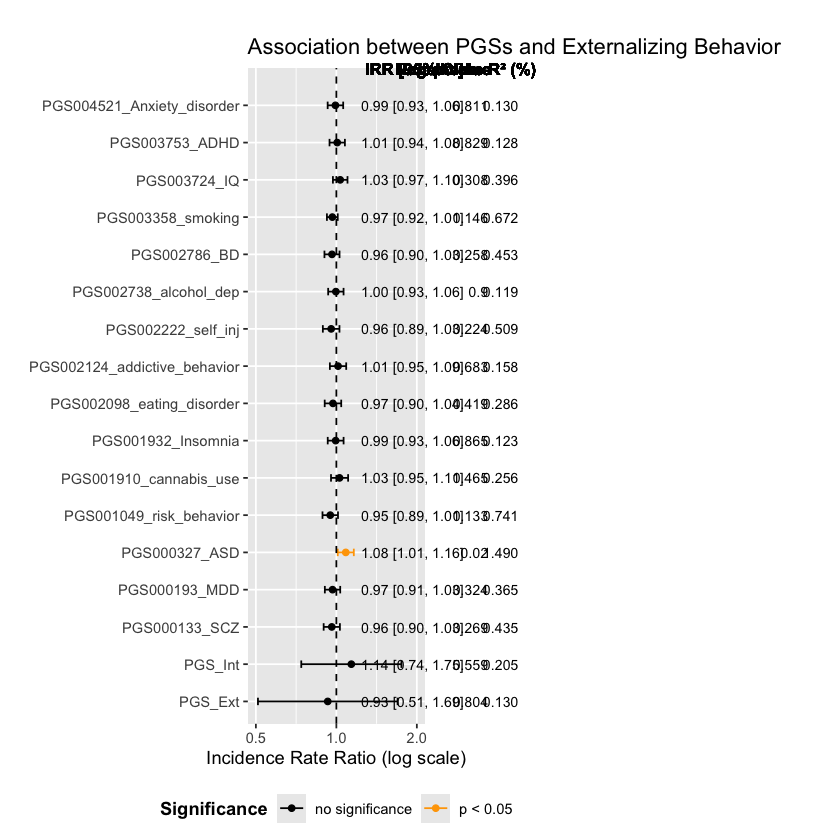

In [76]:
ggplot(results_ext, aes(x = estimate, y = label, color = sig_level)) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
  geom_vline(xintercept = 1, linetype = "dashed") +
  scale_x_log10() +
  scale_color_manual(
    values = c("p < 0.01" = "red",
               "p < 0.05" = "orange",
               "no significance" = "black"),
    name = "Significance"
  ) +
  labs(
    x = "Incidence Rate Ratio (log scale)",
    y = "",
    title = "Association between PGSs and Externalizing Behavior"
  ) +
  # place IRR [CI] labels
  geom_text(aes(x = 3, label = irr_ci), 
            inherit.aes = FALSE, 
            data = results_ext,
            hjust = 1, size = 3, color = "black", y = results_ext$label) +
  # add IRR [CI] header
  geom_text(aes(x = 3, y = length(unique(results_ext$label)) + 1,
                label = "IRR [95% CI]"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +

  # add p-value header
  geom_text(aes(x = 3.8, y = length(unique(results_ext$label)) + 1,
                label = "p-value"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +

  # add p-value values column
  geom_text(aes(x = 3.7, label = round(p.value,3)), 
            inherit.aes = FALSE, 
            data = results_ext,
            hjust = 1, size = 3, color = "black", y = results_ext$label) +

  # add R² values column
  geom_text(aes(x = 4.8, label = r2_fmt), 
            inherit.aes = FALSE, 
            data = results_ext,
            hjust = 1, size = 3, color = "black", y = results_ext$label) +
  # add R² header
  geom_text(aes(x = 5.6, y = length(unique(results_ext$label)) + 1,
                label = "Nagelkerke R² (%)"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +
  coord_cartesian(xlim = c(0.5, 2), clip = "off") +  
  theme(
    plot.margin = margin(23, 250, 5, 5),  # expand right margin for the extra column
    legend.position = "bottom",
    legend.title = element_text(face = "bold"),
    legend.direction = "horizontal"
  )

  ggsave("/Users/drt65393/Documents/Doc/TESE/figuras/sdq_ext.png", width = 11, height = 8, dpi = 300)

In [77]:
results_ext$p_fdr = p.adjust(results_ext$p.value, method = "BH")

In [ ]:
results_ext[, c("term", "p.value", "p_fdr")] # no significance after multiple test correction

term,p.value,p_fdr
<chr>,<dbl>,<dbl>
PGS000133_SCZ,0.2690970,0.6881554
PGS000193_MDD,0.3238378,0.6881554
PGS000327_ASD,0.0203390,0.3457630
PGS001049_risk_behavior,0.1325959,0.6881554
PGS001910_cannabis_use,0.4646394,0.7898870
PGS001932_Insomnia,0.8653939,0.9001506
PGS002098_eating_disorder,0.4192709,0.7898870
PGS002124_addictive_behavior,0.6828077,0.9001506
PGS002222_self_inj,0.2243431,0.6881554


# Testing for SDQ Internalizing problems

In [79]:
# Fit models

models = lapply(independent_vars, function(x) {
  glm.nb(as.formula(paste("internalising ~", x, "+ sex")), data = df)
})

# Tidy results and add Nagelkerke R²
results_int = lapply(models, function(m) {
  # get predictor name
  predictor <- all.vars(formula(m))[2]  # first var after ~

  # compute pseudo-R²
  r2 <- nagelkerke(m)$Pseudo.R.squared.for.model.vs.null["Nagelkerke (Cragg and Uhler)", 1]

  broom::tidy(m, exponentiate = TRUE, conf.int = TRUE) |>
    dplyr::filter(term == predictor) |>   # keep only the main predictor
    dplyr::mutate(
      predictor = predictor,
      r2 = r2*100,
      irr_ci = sprintf("%.2f [%.2f, %.2f]", estimate, conf.low, conf.high),
      pval_fmt = ifelse(p.value < 0.001, "<0.001", sprintf("%.3f", p.value)),
      r2_fmt   = sprintf("%.3f", r2)
    )
})

# Bind into single dataframe
results_int = do.call(rbind, results_int)

# Keep only predictor of interest (drop intercept, sex)
results_int = subset(results_int, term != "(Intercept)" & term != "sex")

results_int <- results_int %>%
  filter(term != "(Intercept)" & term != "sex") %>%
  mutate(
    sig_level = case_when(
      p.value < 0.01 ~ "p < 0.01",
      p.value < 0.05 ~ "p < 0.05",
      TRUE ~ "no significance"
    ),
    # Label still has stars if you want them
    stars = case_when(
      p.value < 0.01 ~ "**",
      p.value < 0.05 ~ "*",
      TRUE ~ ""
    ),
    label = paste0(term)
  )

Warning message:
“Use of `results_int$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 5.5, y = length(unique(results_int$label)) + :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `results_int$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 7.5, y = length(unique(results_int$label)) + :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `results_int$label` is discouraged.
ℹ Use `label` instead.”
Warning message in geom_text(aes(x = 14, y = length(unique(results_int$label)) + :
“All aesthetics have length 1, but the data has 17 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message:
“Use of `result

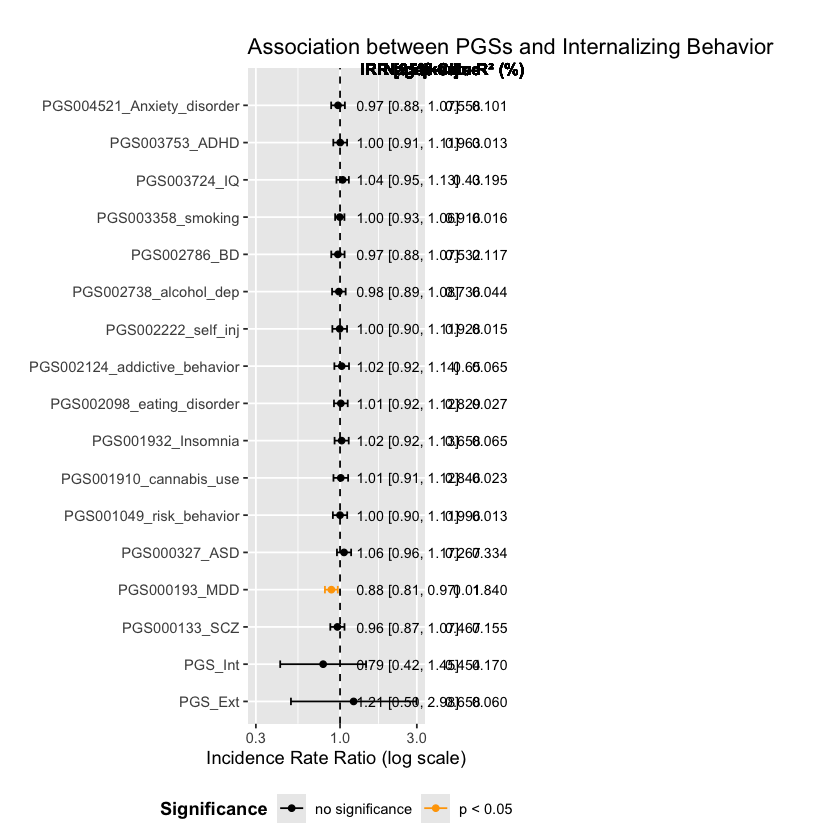

In [80]:
ggplot(results_int, aes(x = estimate, y = label, color = sig_level)) +
  geom_point() +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
  geom_vline(xintercept = 1, linetype = "dashed") +
  scale_x_log10() +
  scale_color_manual(
    values = c("p < 0.01" = "red",
               "p < 0.05" = "orange",
               "no significance" = "black"),
    name = "Significance"
  ) +
  labs(
    x = "Incidence Rate Ratio (log scale)",
    y = "",
    title = "Association between PGSs and Internalizing Behavior"
  ) +
  # place IRR [CI] labels
  geom_text(aes(x = 5.5, label = irr_ci), 
            inherit.aes = FALSE, 
            data = results_int,
            hjust = 1, size = 3, color = "black", y = results_int$label) +
  # add IRR [CI] header
  geom_text(aes(x = 5.5, y = length(unique(results_int$label)) + 1,
                label = "IRR [95% CI]"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +

  # add p-value header
  geom_text(aes(x = 7.5, y = length(unique(results_int$label)) + 1,
                label = "p-value"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +

  # add p-value values column
  geom_text(aes(x = 7.5, label = round(p.value,3)), 
            inherit.aes = FALSE, 
            data = results_int,
            hjust = 1, size = 3, color = "black", y = results_int$label) +

  # add R² values column
  geom_text(aes(x = 11, label = r2_fmt), 
            inherit.aes = FALSE, 
            data = results_int,
            hjust = 1, size = 3, color = "black", y = results_int$label) +
  # add R² header
  geom_text(aes(x = 14, y = length(unique(results_int$label)) + 1,
                label = "Nagelkerke R² (%)"),
            inherit.aes = FALSE, hjust = 1, fontface = "bold", size = 3.5) +
  coord_cartesian(xlim = c(0.3, 3), clip = "off") +  
  theme(
    plot.margin = margin(23, 250, 5, 5),  # expand right margin for the extra column
    legend.position = "bottom",
    legend.title = element_text(face = "bold"),
    legend.direction = "horizontal"
  )

  ggsave("/Users/drt65393/Documents/Doc/TESE/figuras/sdq_int.png", width = 11, height = 8, dpi = 300)

In [ ]:
results_int$p_fdr = p.adjust(results_int$p.value, method = "BH") # no significance after multiple test correction
results_int[, c("term", "p.value", "p_fdr")]

term,p.value,p_fdr
<chr>,<dbl>,<dbl>
PGS000133_SCZ,0.46733791,0.9956808
PGS000193_MDD,0.01040986,0.1769675
PGS000327_ASD,0.26693566,0.9956808
PGS001049_risk_behavior,0.99568084,0.9956808
PGS001910_cannabis_use,0.84603613,0.9956808
PGS001932_Insomnia,0.65778459,0.9956808
PGS002098_eating_disorder,0.82889742,0.9956808
PGS002124_addictive_behavior,0.65013887,0.9956808
PGS002222_self_inj,0.92778575,0.9956808


# Test correlation between the PGSs and the phenotypes

In [82]:
library(corrplot)
library(RColorBrewer)

corrplot 0.95 loaded



In [83]:
colnames(all_pgs)

[1] "sample"                       "PGS000133_SCZ"               
 [3] "PGS000193_MDD"                "PGS000327_ASD"               
 [5] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
 [7] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
 [9] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[11] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[13] "PGS003358_smoking"            "PGS003724_IQ"                
[15] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[17] "PGS_Int"                      "PGS_Ext"

In [84]:
m = cor(all_pgs[, -1])

In [85]:
# Build a "p-value" matrix that encodes your threshold
m = as.matrix(m)

# build a "p-value-like" matrix with same dimnames
p.mat = matrix(0, nrow = nrow(m), ncol = ncol(m),
                dimnames = list(rownames(m), colnames(m)))

p.mat[abs(m) < 0.1] = 1                             # mark "insig" if |r| < 0.1
diag(p.mat) = 0

In [86]:
png("/Users/drt65393/Documents/Doc/TESE/figuras/corrplot_pgs.png", width = 3000, height = 3000, res=300)

corrplot(m,
         method = "color",
         col = c("#B35806", "#E08214", "#FDB863", "#fcecd1", "#e2e5f3", "#aea7d0", "#8073AC", "#542788"),
         type = "upper",
         order = "hclust",
         addCoef.col = "black",
         tl.col = "black",
         diag = FALSE)


dev.off()         

agg_record_797128728 
                   2

In [87]:
print(brewer.pal(n = 8, name = "PuOr"))

[1] "#B35806" "#E08214" "#FDB863" "#FEE0B6" "#D8DAEB" "#B2ABD2" "#8073AC"
[8] "#542788"


In [88]:
col = c("#B35806", "#E08214", "#FDB863", "#FFFFFF", "#d7d9e4", "#B2ABD2", "#8073AC", "#542788")

# Save assocations as tables

In [89]:
# Fit the model
for (y_var in dependent_vars) {
  for (x_var in independent_vars) {
    formula_str <- as.formula(paste(y_var, "~", x_var, "+ sex"))
    
    negbin_model <- tryCatch(
      glm.nb(formula_str, data = df),
      error = function(e) NULL
    )
    
    if (!is.null(negbin_model)) {
      nk <- nagelkerke(negbin_model)
      nagelkerke_r2 <- nk$Pseudo.R.squared.for.model.vs.null["Nagelkerke (Cragg and Uhler)", 1]
      aic_nb <- AIC(negbin_model)
    } else {
      nagelkerke_r2 <- NA
      aic_nb <- NA
    }
    
    # Add results to the lists
    model_results[[length(model_results) + 1]] <- data.frame(
      outcome = y_var,
      predictor = x_var,
      aic_negbin = aic_nb,
      nagelkerke_r2 = nagelkerke_r2
    )
  }
}



In [90]:
all_results = do.call(rbind, model_results)
dim(all_results)

[1] 119   4

In [91]:
head(all_results)

,outcome,predictor,aic_negbin,nagelkerke_r2
,<chr>,<chr>,<dbl>,<dbl>
1,pemotion,PGS000133_SCZ,1453.311,0.000961058
2,pemotion,PGS000193_MDD,1448.102,0.014838000
3,pemotion,PGS000327_ASD,1452.336,0.003573890
4,pemotion,PGS001049_risk_behavior,1453.595,0.000198543
5,pemotion,PGS001910_cannabis_use,1453.351,0.000852973
6,pemotion,PGS001932_Insomnia,1453.389,0.000752558


In [92]:
all_results$nagelkerke_r2 = all_results$nagelkerke_r2*100

In [ ]:
all_results_ordered = all_results[order(all_results$outcome, -all_results$nagelkerke_r2), ]
rownames(all_results_ordered) = NULL
head(all_results_ordered)

,outcome,predictor,aic_negbin,nagelkerke_r2
,<chr>,<chr>,<dbl>,<dbl>
1,externalising,PGS000327_ASD,2121.242,1.489770
2,externalising,PGS001049_risk_behavior,2124.118,0.740536
3,externalising,PGS003358_smoking,2124.379,0.672277
4,externalising,PGS002222_self_inj,2125.002,0.509008
5,externalising,PGS002786_BD,2125.216,0.452994
6,externalising,PGS000133_SCZ,2125.283,0.435349


In [401]:
library(MASS)
library(performance)
library(broom)
library(dplyr)
library(tidyr)
library(gt)

all_results <- list()

for (y in dependent_vars) {
  results_y <- list()
  
  for (x in independent_vars) {
    form <- as.formula(paste(y, "~", x, "+ sex"))
    model <- try(glm.nb(form, data = df), silent = TRUE)
    
    if (inherits(model, "try-error")) next
    
    # Extract coefficients and statistics
    coef_df <- tidy(model) %>% filter(term == x) # Extract only the predictor of interest (ignoring sex and intercept term)
    r2 <- nagelkerke(model)$Pseudo.R.squared.for.model.vs.null["Nagelkerke (Cragg and Uhler)", 1]
    aic <- AIC(model)
    
    results_y[[x]] <- tibble(
      outcome = y,
      predictor = x,
      beta = coef_df$estimate,
      std_error = coef_df$std.error,
      p_value = coef_df$p.value,
      aic = aic,
      nagelkerke_r2 = r2
    )
  }
  
  all_results[[y]] <- bind_rows(results_y) %>%
    arrange(desc(nagelkerke_r2))
}


In [402]:
for (y in names(all_results)) {
  tbl <- all_results[[y]] %>%
    gt() %>%
    fmt_number(columns = c(beta, std_error, p_value, aic, nagelkerke_r2), decimals = 4) %>%
    tab_header(title = paste("Models for", y))
  
  # Save the table as HTMLs
  gtsave(tbl, filename = paste0("results_", y, ".html"))
}


In [403]:
best_prs_per_outcome =  lapply(all_results, function(df) {
  df %>%
    filter(nagelkerke_r2 == max(nagelkerke_r2, na.rm = TRUE)) %>%
    slice(1)
})

# Combina tudo em um único data.frame
best_prs_per_outcome_df = bind_rows(best_prs_per_outcome)
best_prs_per_outcome_df = best_prs_per_outcome_df[order(-best_prs_per_outcome_df$nagelkerke_r2), ]

head(best_prs_per_outcome_df)

outcome,predictor,beta,std_error,p_value,aic,nagelkerke_r2
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pconduct,PGS000327_ASD,0.09398497,0.03916880,0.01641813,1709.558,0.0209095
internalising,PGS000193_MDD,-0.12378140,0.04831608,0.01040986,1766.782,0.0184035
externalising,PGS000327_ASD,0.08108201,0.03494862,0.02033900,2121.242,0.0148977
pemotion,PGS000193_MDD,-0.12183895,0.05317695,0.02195194,1448.102,0.0148380
pebdtot,PGS000327_ASD,0.07294302,0.03500172,0.03716163,2428.057,0.0113609
ppeer,PGS000193_MDD,-0.12895046,0.06695746,0.05412228,1198.880,0.0108107


In [410]:
cov(df2)

,pemotion,pconduct,phyper,ppeer,pprosoc,pebdtot,externalising,internalising,PGS000133_SCZ,PGS000193_MDD,⋯,PGS002098_eating_disorder,PGS002124_addictive_behavior,PGS002222_self_inj,PGS002738_alcohol_dep,PGS002786_BD,PGS003358_smoking,PGS003724_IQ,PGS003753_ADHD,PGS004521_Anxiety_disorder,PGS_Int
pemotion,4.3679790026,1.53497030,2.346760602,1.656188700,-0.50456555,9.9058986048,3.88173090,6.024167703,-0.066637065,-0.301050355,⋯,-0.0429226125,-0.006514149,0.0506885638,-0.079289239,-0.0004129647,0.03189942,0.093298301,-0.054002265,-0.071679107,-0.0177561078
pconduct,1.5349702998,6.03109546,2.466176267,1.181468435,-0.62364968,11.2137104572,8.49727172,2.716438735,-0.183417928,-0.062141588,⋯,-0.0303814563,0.127246969,-0.0375310817,0.170983145,0.0130769728,-0.29899598,0.178363993,-0.059166800,0.019285654,0.0152379298
phyper,2.3467606023,2.46617627,6.428111618,1.263772621,-0.94476447,12.5048211079,8.89428789,3.610533223,-0.067895254,-0.186405313,⋯,-0.1454593669,-0.028209341,-0.2421872324,-0.193391426,-0.2942767069,-0.18551219,0.088492301,0.104915199,-0.071891346,0.0068196191
ppeer,1.6561887001,1.18146843,1.263772621,2.834410830,-0.68608233,6.9358405857,2.44524106,4.490599530,-0.064055096,-0.212111708,⋯,0.0820545325,0.081405835,-0.0650381677,0.014532208,-0.1172831151,-0.06298342,0.076808633,0.062080103,-0.035985592,-0.0046920958
pprosoc,-0.5045655477,-0.62364968,-0.944764470,-0.686082332,2.17838099,-2.7590620251,-1.56841415,-1.190647880,0.065805079,0.090894193,⋯,-0.1306873776,-0.113442715,-0.0687621154,-0.018849746,0.1454421742,0.02944008,-0.133277150,-0.111976390,-0.049255375,0.0032660998
pebdtot,9.9058986048,11.21371046,12.504821108,6.935840586,-2.75906203,40.5602707556,23.71853157,16.841739190,-0.382005344,-0.761708964,⋯,-0.1367089032,0.173929314,-0.2940679179,-0.087165312,-0.3988958139,-0.51559217,0.436963227,0.053826236,-0.160270391,-0.0003906547
externalising,3.8817309021,8.49727172,8.894287885,2.445241055,-1.56841415,23.7185315651,17.39155961,6.326971957,-0.251313183,-0.248546901,⋯,-0.1758408232,0.099037628,-0.2797183140,-0.022408281,-0.2811997341,-0.48450816,0.266856293,0.045748399,-0.052605691,0.0220575489
internalising,6.0241677027,2.71643873,3.610533223,4.490599530,-1.19064788,16.8417391905,6.32697196,10.514767233,-0.130692161,-0.513162063,⋯,0.0391319200,0.074891686,-0.0143496039,-0.064757031,-0.1176960799,-0.03108400,0.170106934,0.008077838,-0.107664700,-0.0224482035
PGS000133_SCZ,-0.0666370654,-0.18341793,-0.067895254,-0.064055096,0.06580508,-0.3820053435,-0.25131318,-0.130692161,1.034542450,0.061381750,⋯,-0.0154786930,0.045121927,0.0034038662,0.044928687,0.2524152528,0.06910193,-0.113693262,0.027430590,0.171909242,0.0126951710
PGS000193_MDD,-0.3010503552,-0.06214159,-0.186405313,-0.212111708,0.09089419,-0.7617089636,-0.24854690,-0.513162063,0.061381750,1.183645849,⋯,0.0603727937,0.078475176,0.0654954881,0.063431380,0.0572415401,0.08753575,-0.071327258,-0.087465757,0.222608769,-0.0054210713


## Multi-PGS - Externalizing behavior

For the Multi-PGS approach we will use ridge regression.

Firsr, the ridge regression model will be used to learn the weights with a gaussian model and then evaluate the resulting multi-PGS in a negative binomial (NB) model. The leakage will be avoided by generating the multi-PGS in an out-of-fold (OOF) sample before using it into the NB model so we don’t overestimate the association/performance

In [94]:
set.seed(123)

In [95]:
colnames(df)

[1] "sample"                       "ID"                          
 [3] "sex"                          "pemotion"                    
 [5] "pconduct"                     "phyper"                      
 [7] "ppeer"                        "pprosoc"                     
 [9] "pebdtot"                      "externalising"               
[11] "internalising"                "PGS000133_SCZ"               
[13] "PGS000193_MDD"                "PGS000327_ASD"               
[15] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
[17] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
[19] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[21] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[23] "PGS003358_smoking"            "PGS003724_IQ"                
[25] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[27] "PGS_Int"                      "PGS_Ext"

In [96]:
y = df$externalising

In [97]:
colnames(x)

[1] "PGS000133_SCZ"                "PGS000193_MDD"               
 [3] "PGS000327_ASD"                "PGS001049_risk_behavior"     
 [5] "PGS001910_cannabis_use"       "PGS001932_Insomnia"          
 [7] "PGS002098_eating_disorder"    "PGS002124_addictive_behavior"
 [9] "PGS002222_self_inj"           "PGS002738_alcohol_dep"       
[11] "PGS002786_BD"                 "PGS003358_smoking"           
[13] "PGS003724_IQ"                 "PGS003753_ADHD"              
[15] "PGS004521_Anxiety_disorder"

In [98]:
cv_ridge = cv.glmnet(as.matrix(x), y, alpha = 0, lambda = 10^seq(-4, 1, length.out = 100))
coef(cv_ridge, s = "lambda.min")

16 x 1 sparse Matrix of class "dgCMatrix"
                               lambda.min
(Intercept)                   6.332595196
PGS000133_SCZ                -0.084367746
PGS000193_MDD                -0.074895376
PGS000327_ASD                 0.209259915
PGS001049_risk_behavior      -0.142713888
PGS001910_cannabis_use        0.079340921
PGS001932_Insomnia           -0.015684824
PGS002098_eating_disorder    -0.063944724
PGS002124_addictive_behavior  0.060973224
PGS002222_self_inj           -0.114790352
PGS002738_alcohol_dep         0.003690074
PGS002786_BD                 -0.093182468
PGS003358_smoking            -0.074479156
PGS003724_IQ                  0.086367598
PGS003753_ADHD               -0.006372460
PGS004521_Anxiety_disorder    0.011692340

In [99]:
colnames(x)

[1] "PGS000133_SCZ"                "PGS000193_MDD"               
 [3] "PGS000327_ASD"                "PGS001049_risk_behavior"     
 [5] "PGS001910_cannabis_use"       "PGS001932_Insomnia"          
 [7] "PGS002098_eating_disorder"    "PGS002124_addictive_behavior"
 [9] "PGS002222_self_inj"           "PGS002738_alcohol_dep"       
[11] "PGS002786_BD"                 "PGS003358_smoking"           
[13] "PGS003724_IQ"                 "PGS003753_ADHD"              
[15] "PGS004521_Anxiety_disorder"

In [100]:
cv_ridge = cv.glmnet(as.matrix(x), y, alpha = 0, lambda = 10^seq(-4, 1, length.out = 100))

# Predictions as vector
predictions = as.numeric(predict(cv_ridge, newx = as.matrix(x), s = "lambda.min", type = "response"))
coef = predict(cv_ridge, newx = x, s = "lambda.min", type = "coefficients"); 
coef 

# Performance metrics
rmse_val = sqrt(mean((y - predictions)^2))
r2_val   = cor(predictions, y)^2

res_ext = data.frame(
  RMSE   = rmse_val,
  R2     = r2_val,
  alpha  = 0,
  lambda = cv_ridge$lambda.min,
  N      = nrow(x)
)

head(res_ext)


16 x 1 sparse Matrix of class "dgCMatrix"
                               lambda.min
(Intercept)                   6.317786376
PGS000133_SCZ                -0.069132080
PGS000193_MDD                -0.060777586
PGS000327_ASD                 0.165580503
PGS001049_risk_behavior      -0.112977371
PGS001910_cannabis_use        0.061720895
PGS001932_Insomnia           -0.011846195
PGS002098_eating_disorder    -0.051409606
PGS002124_addictive_behavior  0.045268781
PGS002222_self_inj           -0.091191263
PGS002738_alcohol_dep         0.001485543
PGS002786_BD                 -0.074350771
PGS003358_smoking            -0.060927139
PGS003724_IQ                  0.068340697
PGS003753_ADHD               -0.001385765
PGS004521_Anxiety_disorder    0.004717073

,RMSE,R2,alpha,lambda,N
,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,4.107806,0.05111772,0,8.902151,381


In [101]:
  # Calculate multiPGS
  w = as.vector(coef)[-1]
  p = as.matrix(x)
  
  multi_pgs_ext <- p %*% w
  out = data.frame(df$sample, df$externalising, multi_pgs_ext, df$sex)

In [102]:
colnames(out)

[1] "df.sample"        "df.externalising" "multi_pgs_ext"    "df.sex"

In [ ]:
fit = glm.nb(df.externalising ~ multi_pgs_ext + df.sex, data=out) # fit regression model    
broom::tidy(fit, exponentiate = TRUE, conf.int = TRUE) # link function of negative binomial is on the log scale log(E[Y])=β0​+β1​×multi_pgs_ext+β2​×sexmale

r = nagelkerke(fit)$Pseudo.R.squared.for.model.vs.null[2]
r

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.234152,0.04823136,37.9430011,5.033254e-315,5.6730844,6.857449
multi_pgs_ext,1.658586,0.11920918,4.2443509,2.192271e-05,1.3135567,2.096474
df.sexmale,1.051327,0.07110564,0.7039322,4.814750e-01,0.9147434,1.208566


[1] 0.0463617

In [104]:
r*100

[1] 4.63617

In [543]:
### Plot the effects
stats_ext = rbind(res_ext[,c("R2")], coef2)
rownames(stats_ext)[1] = c("R2")

In [544]:
head(stats_ext)

R2,0.05088793
PGS000133_SCZ,-0.06428132
PGS000193_MDD,-0.05636980
PGS000327_ASD,0.15230885
PGS001049_risk_behavior,-0.10391685
PGS001910_cannabis_use,0.05645282


In [545]:
stats_ext = as.data.frame(stats_ext)

In [546]:
head(stats_ext)

,V1
,<dbl>
R2,0.05088793
PGS000133_SCZ,-0.06428132
PGS000193_MDD,-0.05636980
PGS000327_ASD,0.15230885
PGS001049_risk_behavior,-0.10391685
PGS001910_cannabis_use,0.05645282


In [ ]:
stats_ext$highlight = ifelse(1:nrow(stats_ext) == 1, "R2", "PGS Coefficients")

In [548]:
colnames(stats_ext)

[1] "V1"        "highlight"

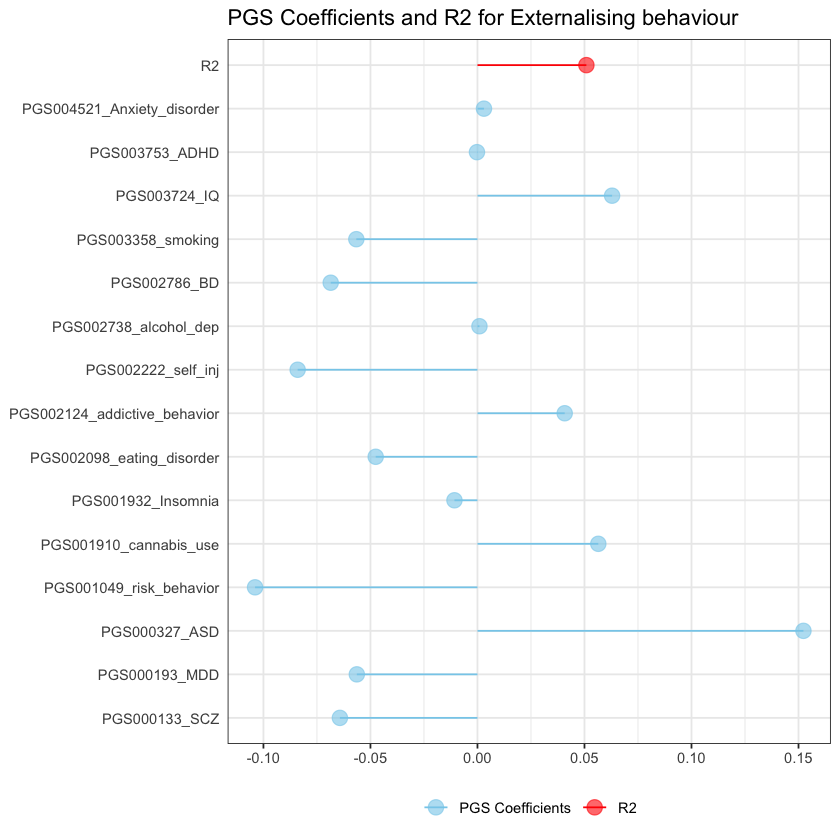

In [622]:
# Horizontal version
ggplot(stats_ext, aes(x = rownames(stats_ext), y = V1)) +
  geom_segment(aes(xend = rownames(stats_ext), yend = V1, color = highlight),
               y = 0) +
  geom_point(aes(color = highlight), size = 4, alpha = 0.6) +
  scale_color_manual(values = c("R2" = "red", "PGS Coefficients" = "skyblue")) +
  theme_bw() +
  coord_flip() +
  ggtitle("PGS Coefficients and R2 for Externalising behaviour") +
  theme(
    #panel.grid.major.y = element_blank(),
    #panel.border = element_blank(),
    axis.ticks.y = element_blank(),
    legend.position = "bottom", 
    legend.title = element_blank(),
    axis.title.y = element_blank(),
    axis.title.x = element_blank()
  )

ggsave("/Users/drt65393/Documents/Doc/TESE/figuras/multipgs_ext.png", width = 9, height = 8, dpi = 300)

## Internalising behavior

In [106]:
y = df$internalising

In [107]:
cv_ridge = cv.glmnet(as.matrix(x), y, alpha = 0, lambda = 10^seq(-4, 1, length.out = 100))

# Predictions as vector
predictions = as.numeric(predict(cv_ridge, newx = as.matrix(x), s = "lambda.min", type = "response"))
coef = predict(cv_ridge, newx = x, s = "lambda.min", type = "coefficients"); 
coef 

16 x 1 sparse Matrix of class "dgCMatrix"
                                lambda.min
(Intercept)                   3.2945331402
PGS000133_SCZ                -0.0268910842
PGS000193_MDD                -0.1050696542
PGS000327_ASD                 0.0465802379
PGS001049_risk_behavior      -0.0006063056
PGS001910_cannabis_use        0.0102082293
PGS001932_Insomnia            0.0191381817
PGS002098_eating_disorder     0.0116863035
PGS002124_addictive_behavior  0.0212135476
PGS002222_self_inj           -0.0023163235
PGS002738_alcohol_dep        -0.0123733065
PGS002786_BD                 -0.0225919047
PGS003358_smoking            -0.0014086202
PGS003724_IQ                  0.0304046240
PGS003753_ADHD               -0.0027594157
PGS004521_Anxiety_disorder   -0.0160308755

In [108]:
  # Calculate multiPGS
  w = as.vector(coef)[-1]
  p = as.matrix(x)
  
  multi_pgs_int = p %*% w
  out2 = data.frame(df$sample, df$internalising, multi_pgs_int, df$sex)

In [109]:
fit = glm.nb(df.internalising ~ multi_pgs_int + df.sex, data=out2) # fit regression model    #return(summary(fit)$adj.r.squared) # return adjusted R-squared of model
broom::tidy(fit, exponentiate = TRUE, conf.int = TRUE) # link function of negative binomial is on the log scale log(E[Y])=β0​+β1​×multi_pgs_ext+β2​×sexmale

r = nagelkerke(fit)$Pseudo.R.squared.for.model.vs.null[2]
r*100

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.3698090,0.07095145,17.1223582,1.010957e-65,2.9353076,3.879320
multi_pgs_int,3.0002943,0.36469875,3.0126518,2.589758e-03,1.5125022,5.993381
df.sexmale,0.9589797,0.10512560,-0.3984316,6.903121e-01,0.7803438,1.179010


[1] 2.54196

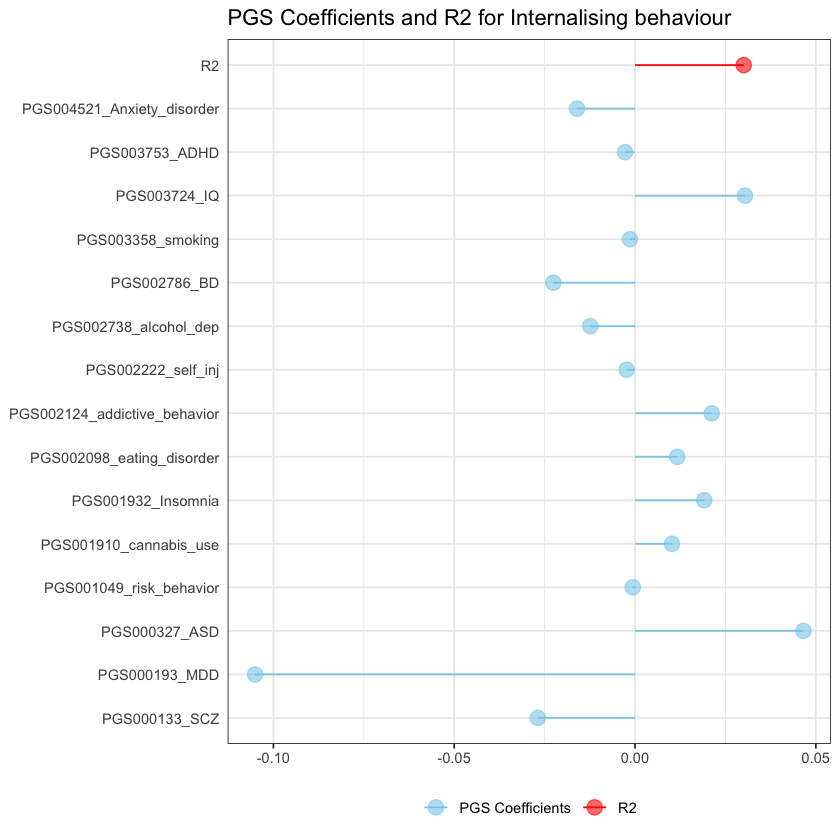

In [634]:
coef = as.data.frame(as.matrix(coef))
coef$PGS = rownames(coef)
coef = coef[2:nrow(coef), ]
coef$PGS = NULL

### Plot the effects
stats_int = rbind(res_ext[,c("R2")], coef)
rownames(stats_int)[1] = c("R2")

stats_int$lambda.min = as.numeric(stats_int$lambda.min)
stats_int$highlight <- ifelse(1:nrow(stats_int) == 1, "R2", "PGS Coefficients")

# Horizontal version
ggplot(stats_int, aes(x = rownames(stats_int), y = lambda.min)) +
  geom_segment(aes(xend = rownames(stats_int), yend = lambda.min, color = highlight),
               y = 0) +
  geom_point(aes(color = highlight), size = 4, alpha = 0.6) +
  scale_color_manual(values = c("R2" = "red", "PGS Coefficients" = "skyblue")) +
  theme_bw() +
  coord_flip() +
  ggtitle("PGS Coefficients and R2 for Internalising behaviour") +
  theme(
    #panel.grid.major.y = element_blank(),
    #panel.border = element_blank(),
    axis.ticks.y = element_blank(),
    legend.position = "bottom", 
    legend.title = element_blank(),
    axis.title.y = element_blank(),
    axis.title.x = element_blank()
  )

ggsave("/Users/drt65393/Documents/Doc/TESE/figuras/multipgs_int.png", width = 9, height = 8, dpi = 300)

In [110]:
colnames(out)

[1] "df.sample"        "df.externalising" "multi_pgs_ext"    "df.sex"

In [111]:
colnames(out2)

[1] "df.sample"        "df.internalising" "multi_pgs_int"    "df.sex"

In [112]:
## Save multipgs 
multi = merge(out, out2, by="df.sample")
colnames(multi)

[1] "df.sample"        "df.externalising" "multi_pgs_ext"    "df.sex.x"        
[5] "df.internalising" "multi_pgs_int"    "df.sex.y"

In [113]:
multi = multi[, c("df.sample", "multi_pgs_ext", "multi_pgs_int")]
names(multi) = c("sample", "multi_pgs_ext", "multi_pgs_int")
dim(multi)

[1] 381   3

In [114]:
head(multi)

,sample,multi_pgs_ext,multi_pgs_int
,<chr>,<dbl>,<dbl>
1,206182310135_R01C01,-0.33872172,-0.14848744
2,206182310135_R02C01,-0.15096512,-0.17714125
3,206182310135_R04C01,0.03404936,0.12690850
4,206182310135_R05C01,-0.29499480,-0.21313336
5,206182310135_R07C01,0.19719998,0.06455441
6,206182320002_R01C01,-0.10298533,-0.11589446


In [115]:
dim(df); colnames(df)
df[, c(29,30)] = NULL
dim(df)

[1] 381  28

[1] "sample"                       "ID"                          
 [3] "sex"                          "pemotion"                    
 [5] "pconduct"                     "phyper"                      
 [7] "ppeer"                        "pprosoc"                     
 [9] "pebdtot"                      "externalising"               
[11] "internalising"                "PGS000133_SCZ"               
[13] "PGS000193_MDD"                "PGS000327_ASD"               
[15] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
[17] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
[19] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[21] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[23] "PGS003358_smoking"            "PGS003724_IQ"                
[25] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[27] "PGS_Int"                      "PGS_Ext"

[1] 381  28

In [116]:
pgs_df = merge(df, multi, by = "sample")
head(pgs_df)

,sample,ID,sex,pemotion,pconduct,phyper,ppeer,pprosoc,pebdtot,externalising,⋯,PGS002738_alcohol_dep,PGS002786_BD,PGS003358_smoking,PGS003724_IQ,PGS003753_ADHD,PGS004521_Anxiety_disorder,PGS_Int,PGS_Ext,multi_pgs_ext,multi_pgs_int
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,206182310135_R01C01,266,female,3,1,3,3,10,10,4,⋯,0.2816256,1.61194200,0.20220784,0.6495411,0.9335897,0.7683924,0.08915865,-0.07948094,-0.33872172,-0.14848744
2,206182310135_R02C01,1337,female,2,0,2,0,10,4,2,⋯,-1.8294617,0.27373289,-0.06071188,-2.3025308,-1.3664342,2.4419432,0.27126052,0.05753460,-0.15096512,-0.17714125
3,206182310135_R04C01,6257,female,4,7,6,4,4,21,13,⋯,-1.8803174,-0.86537592,1.03873388,2.0920458,0.3938854,-1.0834491,-0.05197157,-0.04599166,0.03404936,0.12690850
4,206182310135_R05C01,52,female,0,0,0,2,10,2,0,⋯,-0.5437400,1.59162087,-0.13140753,-0.9153862,1.6923068,-0.1407761,-0.02193859,-0.05702520,-0.29499480,-0.21313336
5,206182310135_R07C01,3374,male,1,3,3,0,8,7,6,⋯,-0.8423609,-1.10974378,-2.86846734,0.4760312,0.2809325,1.0280763,-0.03595845,-0.02910183,0.19719998,0.06455441
6,206182320002_R01C01,3340,female,5,0,2,0,10,7,2,⋯,-0.8935329,0.01464477,0.61134053,0.2379913,-1.2956117,-1.0592156,0.13505695,-0.12455334,-0.10298533,-0.11589446


In [117]:
dim(pgs_df)

[1] 381  30

In [118]:
getwd()

[1] "/Users/drt65393/Documents/roc/roc_paper_2024/05_2025_pgscalc_analysis"

In [119]:
write.table(pgs_df, file = "./score/08_2025_roc_with_pgs.tsv", sep = "\t", row.names = FALSE, quote = FALSE)

In [120]:
cor(df[, c("externalising", "internalising", "pebdtot")]) # int and ext 0.47 = moderate overlap but clearly distinct.

,externalising,internalising,pebdtot
externalising,1.0000000,0.4678717,0.8930342
internalising,0.4678717,1.0000000,0.8155239
pebdtot,0.8930342,0.8155239,1.0000000


In [121]:
M = cor(df[, -c(1:8, 30)])

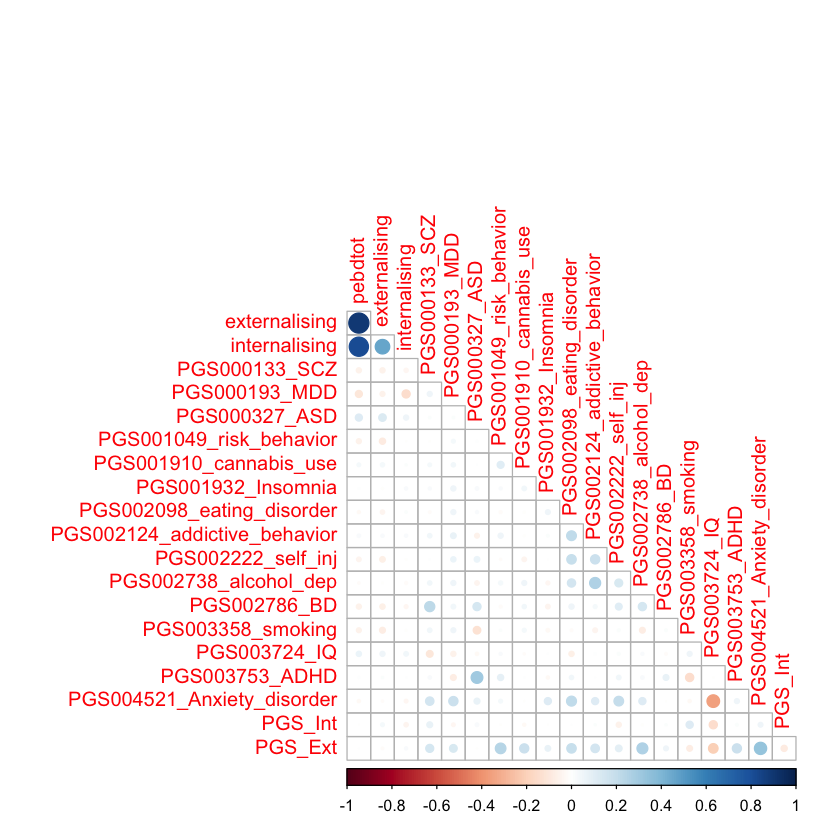

In [122]:
corrplot(M, type = 'lower', diag = FALSE)

In [123]:
colnames(M)

[1] "pebdtot"                      "externalising"               
 [3] "internalising"                "PGS000133_SCZ"               
 [5] "PGS000193_MDD"                "PGS000327_ASD"               
 [7] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
 [9] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
[11] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[13] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[15] "PGS003358_smoking"            "PGS003724_IQ"                
[17] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[19] "PGS_Int"                      "PGS_Ext"

In [124]:
M = M %>%
  as.data.frame() %>%
  rename(
    SDQ_total = pebdtot,
    SDQ_externalizing = externalising,
    SDQ_internalizing = internalising) %>% as.matrix()

In [125]:
colnames(M)

[1] "SDQ_total"                    "SDQ_externalizing"           
 [3] "SDQ_internalizing"            "PGS000133_SCZ"               
 [5] "PGS000193_MDD"                "PGS000327_ASD"               
 [7] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
 [9] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
[11] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[13] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[15] "PGS003358_smoking"            "PGS003724_IQ"                
[17] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[19] "PGS_Int"                      "PGS_Ext"

In [126]:
rownames(M)

[1] "pebdtot"                      "externalising"               
 [3] "internalising"                "PGS000133_SCZ"               
 [5] "PGS000193_MDD"                "PGS000327_ASD"               
 [7] "PGS001049_risk_behavior"      "PGS001910_cannabis_use"      
 [9] "PGS001932_Insomnia"           "PGS002098_eating_disorder"   
[11] "PGS002124_addictive_behavior" "PGS002222_self_inj"          
[13] "PGS002738_alcohol_dep"        "PGS002786_BD"                
[15] "PGS003358_smoking"            "PGS003724_IQ"                
[17] "PGS003753_ADHD"               "PGS004521_Anxiety_disorder"  
[19] "PGS_Int"                      "PGS_Ext"

In [127]:
rownames(M) = colnames(M)

In [128]:
png("/Users/drt65393/Documents/Doc/TESE/figuras/corrplot_pgs_phen.png", width = 3500, height = 3500, res=300)

corrplot(M,
         method = "color",
         col = c("#B35806", "#E08214", "#FDB863", "#fcecd1", "#e2e5f3", "#aea7d0", "#8073AC", "#542788"),
         type = "upper",
         order = "hclust",
         addCoef.col = "black",
         tl.col = "black",
         diag = FALSE)


dev.off()

agg_record_2027170101 
                    2